In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker
import numpy as np
import importlib
import xarray as xr
import nc_time_axis
import cmocean
import cmocean.cm as cmo
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Patch, Polygon
import matplotlib.ticker as mticker
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import shapely.geometry as sgeom
from matplotlib.lines import Line2D as Line
from matplotlib.patheffects import Stroke
import mpl_toolkits.axes_grid1.inset_locator as il
import cv2
import glob
import nc_time_axis
from eofs.xarray import Eof
import scipy.signal as sps
import scipy.linalg as spl
from scipy import stats
from matplotlib import gridspec
from scipy.signal import butter, lfilter
from functools import partial
from matplotlib.lines import Line2D

from statsmodels.tsa.seasonal import STL
import pandas as pd
from scipy.integrate import odeint
import _pickle as cPickle
import os,sys
from matplotlib.font_manager import FontProperties
import string
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ultraplot as pplt

import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Polygon

import pop_tools

In [2]:
mpl.rcParams['figure.dpi'] = 100


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [5]:
def eof_indian(x):
    
    sl = x.copy()
    
    if 'time_counter' in sl.coords:
        sl = sl.rename ( {'time_counter':'time'} )
    else:
        pass
        
    sl = sl.sel(lat=slice(-21,21))
    
    #sl_indian_clim = sl_indian.groupby('time.month').mean(dim='time')
    #sl_indian = sl_indian.groupby('time.month') - sl_indian_clim
    
    #sl_indian = detrend(sl_indian.fillna(0), 'time', detrend_type="linear")

    y = sl.sel(lat=slice(-21,21)).coords['lat'].values
    coslat = np.cos(np.deg2rad(y))
    wgts = np.sqrt(coslat)[...,np.newaxis]
    
    solver = Eof(sl,weights=wgts)

    eof = solver.eofs(neofs=3)
    pc = solver.pcs(npcs=3)
    
    pc1 = pc.sel(mode=0)
    
    pc1 = pc1/pc1.std()
    
    pc2 = pc.sel(mode=1)

    pc2 = pc2/pc2.std()
    
    pc3 = pc.sel(mode=2)
    
    pc3 = pc3/pc3.std()
    
    eof1 = eof.sel(mode=0)
    eof2 = eof.sel(mode=1)
    eof3 = eof.sel(mode=2)
    
    var_expl = solver.varianceFraction(neigs=3)
    
    return pc1, pc2, pc3, eof1, eof2, eof3, var_expl


def lag_linregress_3D(x, y, time='time',lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim=time)

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim=time)
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim=time)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  ((x - xmean)*(y - ymean)).sum(axis=0)/(n)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    
    return cov,cor,slope,intercept,pval,stderr


def poly(x,y,color='k',ax=None):
    poly_corners = np.zeros((len(y), 2), np.float64)
    poly_corners[:,0] = x
    poly_corners[:,1] = y

    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False,lw=2, transform=ccrs.PlateCarree())

    return ax.add_patch(poly)

def anom(ds):
    
    ds_clim = ds.groupby('time.month').mean(dim='time')
    ds_anom = ds.groupby('time.month') - ds_clim
    
    return ds_anom

def NINO34_idx(sst,time='time'):
    
    if sst.lat.values[0] < 0:
        sst = sst.sel(lat=slice(-6,6),lon=slice(360-170,360-120))
    else:
        sst = sst.sel(lat=slice(6,-6),lon=slice(360-170,360-120))
        
    nino34 = sst.mean(dim=('lat','lon'))
    
    return anom(nino34)

def NINO34(sst,model=None,time='time'):
    
    if sst.lat.values[0] < 0:
        sst = sst.sel(lat=slice(-6,6),lon=slice(360-170,360-120))
    else:
        sst = sst.sel(lat=slice(6,-6),lon=slice(360-170,360-120))

    return sst.mean(dim=('lat','lon'))


def EIO(sst,model=None,time='time'):
    
    if sst.lat.values[0] < 0:
        sst_EIO = sst.sel(lat=slice(-11,0),lon=slice(90,110))
    else:
        sst_EIO = sst.sel(lat=slice(0,-11),lon=slice(90,110))

    return sst_EIO.mean(dim=('lat','lon'))


def WIO(sst,model=None,time='time'):
    
    if sst.lat.values[0] < 0:
        sst_WIO = sst.sel(lat=slice(-11,11),lon=slice(50,70))
    else:
        sst_WIO = sst.sel(lat=slice(11,-11),lon=slice(50,70))

    return sst_WIO.mean(dim=('lat','lon'))

def DMI(sst,model=None,time='time'):
    
    sst_DMI = WIO(sst) - EIO(sst)
    
    return sst_DMI

def DMI_idx(ds):
    return anom(WIO(ds)) - anom(EIO(ds))

In [ ]:
!ls landfrac*

landfrac_21ka.nc


In [29]:
landfrac = xr.open_dataset('landfrac_21ka.nc').LANDFRAC

In [30]:
temp_adj = xr.open_dataset('variables/adjusted/TS.full.2Ma.mon.masked_monlenadj_hm.nc',decode_times=False)['TS']

In [31]:
mask = xr.open_dataset('variables/pCESM.2Ma_SSH.100yr.nc',decode_times=False).SSH
mask = mask.sel(lon=slice(temp_adj.lon.min().values,temp_adj.lon.max().values),
               lat=slice(temp_adj.lat.min().values,temp_adj.lat.max().values))

In [32]:
mask_ocean = 2 * np.ones((len(mask.coords['lat']), len(mask.coords['lon']))) * np.isfinite(mask[0])  
mask_land = 1 * np.ones((len(mask.coords['lat']), len(mask.coords['lon']))) * np.isnan(mask[0])  
mask_array = mask_ocean + mask_land

In [33]:
# times = xr.cftime_range(start="0001-01-01 00:00:00", periods=4800012, freq="1MS", calendar="360_day").values

In [34]:
import pickle

# with open('variables/times.pkl', 'wb') as f:
#     pickle.dump(times, f)

with open('variables/times.pkl', 'rb') as f:
    loaded_times = pickle.load(f)

In [35]:
temp_adj['time'] = loaded_times

In [51]:
ds_slopes_nino34 = xr.open_dataset('variables/slopes_temp_nino34_adj.nc')
ds_slopes_dmi = xr.open_dataset('variables/slopes_temp_dmi_adj.nc')

In [8]:
import pickle

# Load datasets from pickles
loaded_datasets_nino34 = {}
loaded_datasets_dmi = {}

nino34_names = ['pc1_nino34', 'pc2_nino34', 'pc3_nino34', 'eof1_nino34', 'eof2_nino34', 'eof3_nino34', 'var_expl_nino34']
dmi_names = ['pc1_dmi', 'pc2_dmi', 'pc3_dmi', 'eof1_dmi', 'eof2_dmi', 'eof3_dmi', 'var_expl_dmi']

for name in nino34_names:
    with open(f'variables/{name}.pkl', 'rb') as f:
        loaded_datasets_nino34[name] = pickle.load(f)

for name in dmi_names:
    with open(f'variables/{name}.pkl', 'rb') as f:
        loaded_datasets_dmi[name] = pickle.load(f)

# Access the loaded datasets
pc1_nino34 = loaded_datasets_nino34['pc1_nino34']
pc2_nino34 = loaded_datasets_nino34['pc2_nino34']
pc3_nino34 = loaded_datasets_nino34['pc3_nino34']
eof1_nino34 = loaded_datasets_nino34['eof1_nino34']
eof2_nino34 = loaded_datasets_nino34['eof2_nino34']
eof3_nino34 = loaded_datasets_nino34['eof3_nino34']
var_expl_nino34 = loaded_datasets_nino34['var_expl_nino34']

pc1_dmi = loaded_datasets_dmi['pc1_dmi']
pc2_dmi = loaded_datasets_dmi['pc2_dmi']
pc3_dmi = loaded_datasets_dmi['pc3_dmi']
eof1_dmi = loaded_datasets_dmi['eof1_dmi']
eof2_dmi = loaded_datasets_dmi['eof2_dmi']
eof3_dmi = loaded_datasets_dmi['eof3_dmi']
var_expl_dmi = loaded_datasets_dmi['var_expl_dmi']

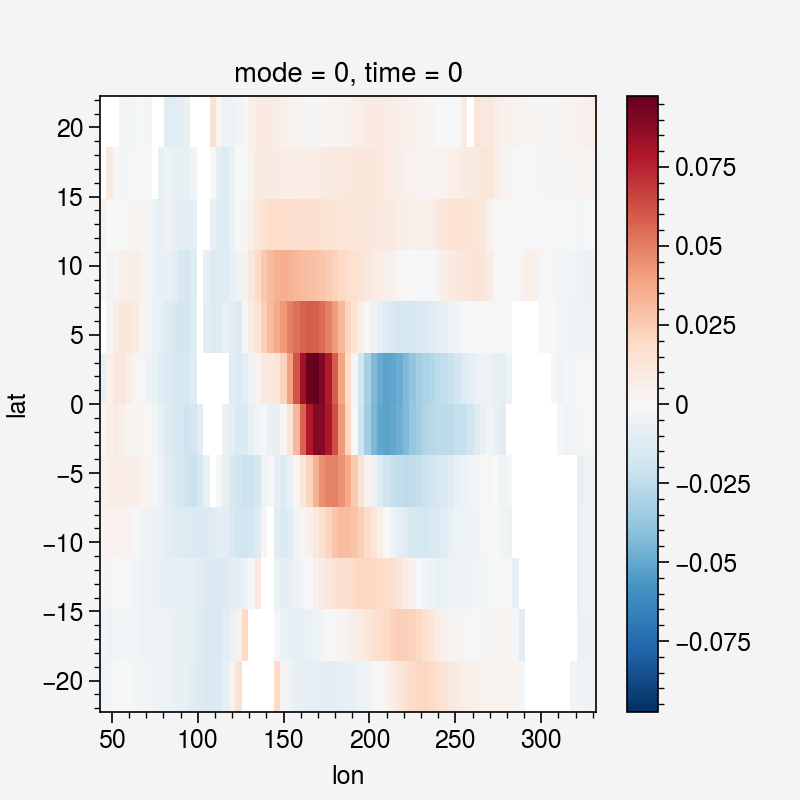

In [9]:
(-eof1_nino34*-pc1_nino34[-pc1_nino34<0][0]).plot()

In [14]:
#year, orb_year, eccentricity, obliquity, longitude of perihelion, and precession index (6th column)
# 2 Ma [74880:]
df = pd.read_csv("variables/pCESM.2Ma_orbPara.txt", sep="\s+", header=None)
#dt = np.arange(df[0][0]+1,df[0][20000]+1,1)

In [20]:
dt = np.arange(df[0][0]+1,df[0][20000]+1,1)

/var/folders/79/vynhz9j51zs860r546q02m6c0000gn/T/ipykernel_15546/3661589171.py:48: UltraPlotWarning: fig.subplots_adjust() has no effect on ultraplot figures. To set the left, right, bottom, top, wspace, or hspace gridspec values, pass them as keyword arguments to uplt.figure() or uplt.subplots(). Please note they are now specified in physical units, with strings interpreted by uplt.units() and floats interpreted as font size-widths.
  plt.subplots_adjust(hspace=0.3, wspace=0.25)
/var/folders/79/vynhz9j51zs860r546q02m6c0000gn/T/ipykernel_15546/3661589171.py:49: UltraPlotWarning: fig.tight_layout() has no effect on ultraplot figures. ultraplot uses its own tight layout algorithm that is activated by default. To disable it, set uplt.rc['subplots.tight'] to False or pass tight=False to uplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


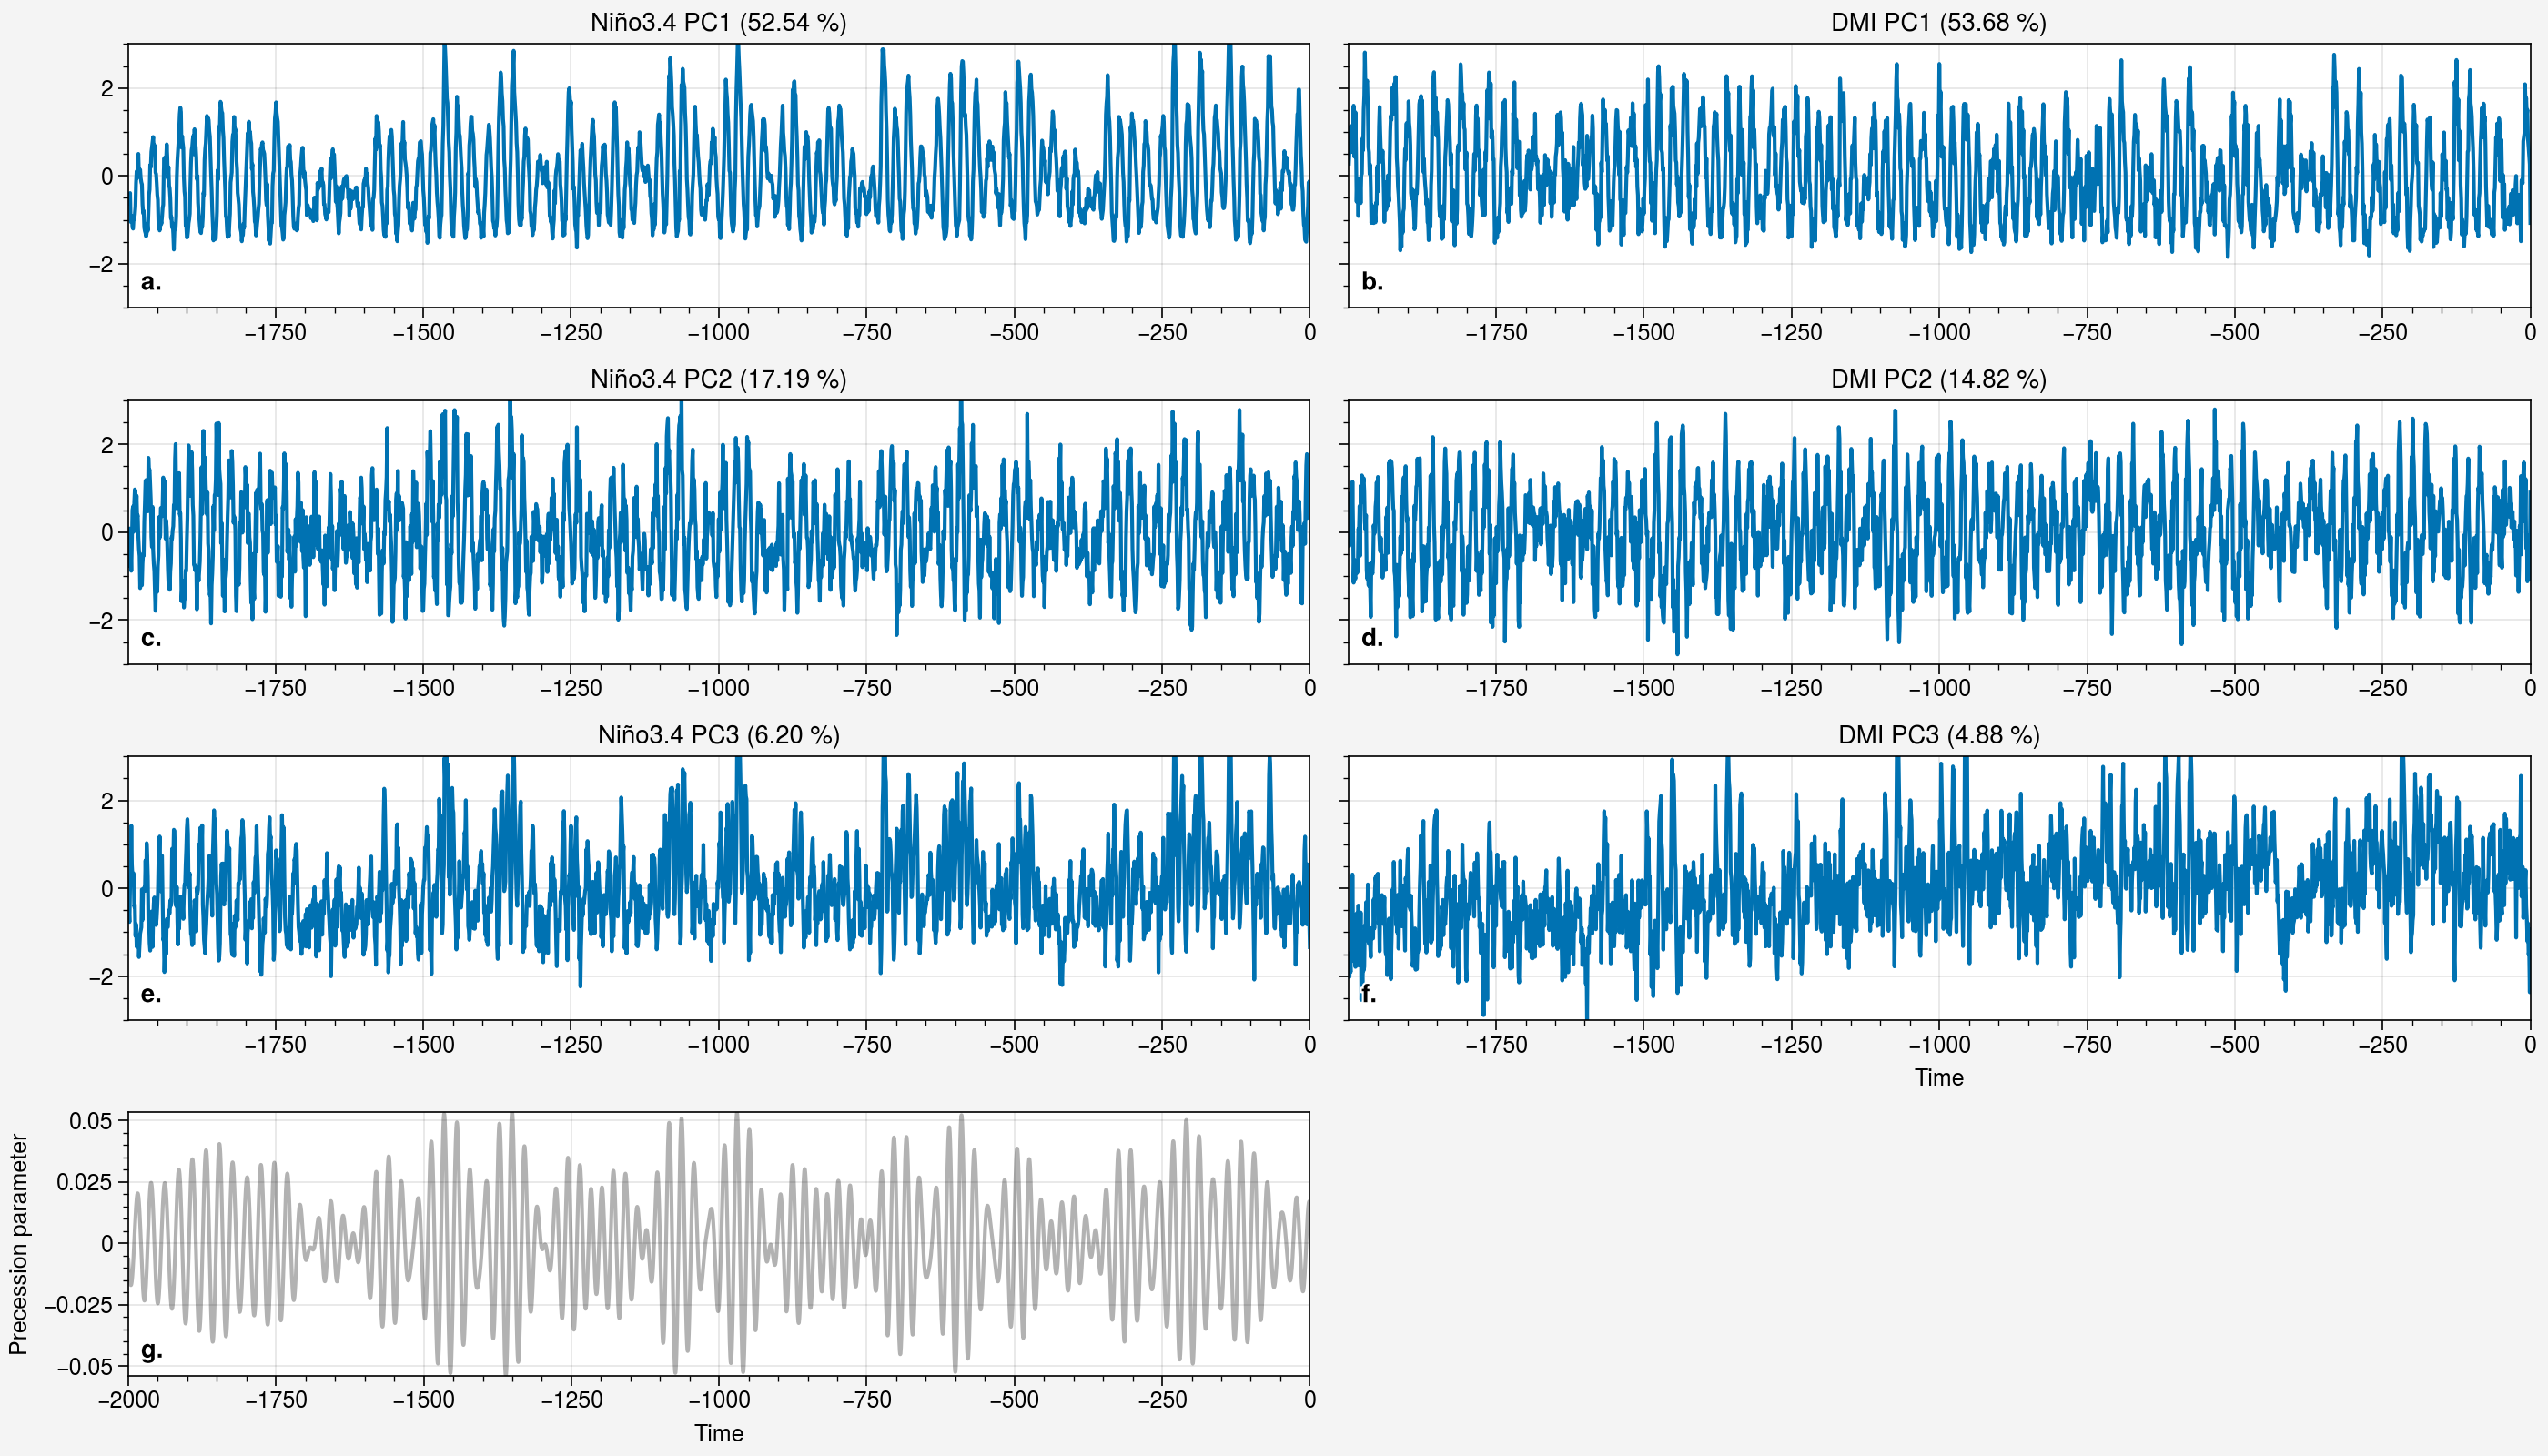

In [41]:
# Figures: Niño3.4 and DMI EOF Analyses - Principal Components

fig, axs = pplt.subplots(nrows=4, ncols=2, figsize=(14, 8), sharex=False)

# Left column: Niño3.4 PCs
axs[0, 0].plot(dt, -pc1_nino34)
axs[0, 0].set_ylim(-3, 3)
axs[0, 0].set_title('Niño3.4 PC1 ({:.2f} %)'.format(var_expl_nino34[0].values * 100))
axs[0, 0].set_ylabel(' ')

axs[1, 0].plot(dt, pc2_nino34)
axs[1, 0].set_ylim(-3, 3)
axs[1, 0].set_title('Niño3.4 PC2 ({:.2f} %)'.format(var_expl_nino34[1].values * 100))
axs[1, 0].set_ylabel(' ')

axs[2, 0].plot(dt, pc3_nino34)
axs[2, 0].set_ylim(-3, 3)
axs[2, 0].set_title('Niño3.4 PC3 ({:.2f} %)'.format(var_expl_nino34[2].values * 100))
axs[2, 0].set_ylabel(' ')

axs[3, 0].plot(df[0], df[5], c='k', alpha=.3)
axs[3, 0].set_ylim(df[5].min(), df[5].max())
axs[3, 0].set_xlim(df[0].min(), df[0].max())
axs[3, 0].set_ylabel('Precession parameter')
axs[3,0].set_xlabel('Time')

# Right column: DMI PCs
axs[0, 1].plot(dt, -pc1_dmi)
axs[0, 1].set_ylim(-3, 3)
axs[0, 1].set_title('DMI PC1 ({:.2f} %)'.format(var_expl_dmi[0].values * 100))
axs[0, 1].set_ylabel(' ')

axs[1, 1].plot(dt, pc2_dmi)
axs[1, 1].set_ylim(-3, 3)
axs[1, 1].set_title('DMI PC2 ({:.2f} %)'.format(var_expl_dmi[1].values * 100))
axs[1, 1].set_ylabel(' ')

axs[2, 1].plot(dt, pc3_dmi)
axs[2, 1].set_ylim(-3, 3)
axs[2, 1].set_title('DMI PC3 ({:.2f} %)'.format(var_expl_dmi[2].values * 100))
axs[2,1].set_xlabel('Time')
axs[2, 1].set_ylabel(' ')

axs[3, 1].axis('off')
    
axs[0:7].format(abc='a.',abcloc='ll')

plt.subplots_adjust(hspace=0.3, wspace=0.25)
plt.tight_layout()

plt.savefig("pcs_time_series.png", dpi=300, format='png',
    bbox_inches='tight', #pad_inches=.3,
   transparent=True  )  

plt.show()


In [7]:
ds_orb = df.to_xarray().rename({'index':'time'})#.isel(time=slice(None, None, -1))
ds_orb['time'] = ds_orb[0]

In [8]:
df_co2 = pd.read_csv("variables/Insol_GHG_d18o_0ka_2000.txt", sep="\s+", header=None)
ds_co2 = df_co2.to_xarray().rename({'index':'time'}).isel(time=slice(None, None, -1))
ds_co2['time'] = -ds_co2['time'] 

In [9]:
co2 = ds_co2.interp(time=ds_orb['time'])[2]

co2_ = co2.rename({'time':'year'})
co2_ = co2_.interp(year=-np.arange(0,4800012,1)[::-1]/12*5/1000)

In [10]:
sle = ds_co2.interp(time=ds_orb['time'])[7]
sle_ = sle.rename({'time':'year'})
sle_ = sle_.interp(year=-np.arange(0,4800012,1)[::-1]/12*5/1000)

In [7]:
params_ = xr.open_dataset('variables/pCESM.2Ma_orbPara.nc')
params = params_.interp(year=-np.arange(0,4800012,1)[::-1]/12*5/1000)

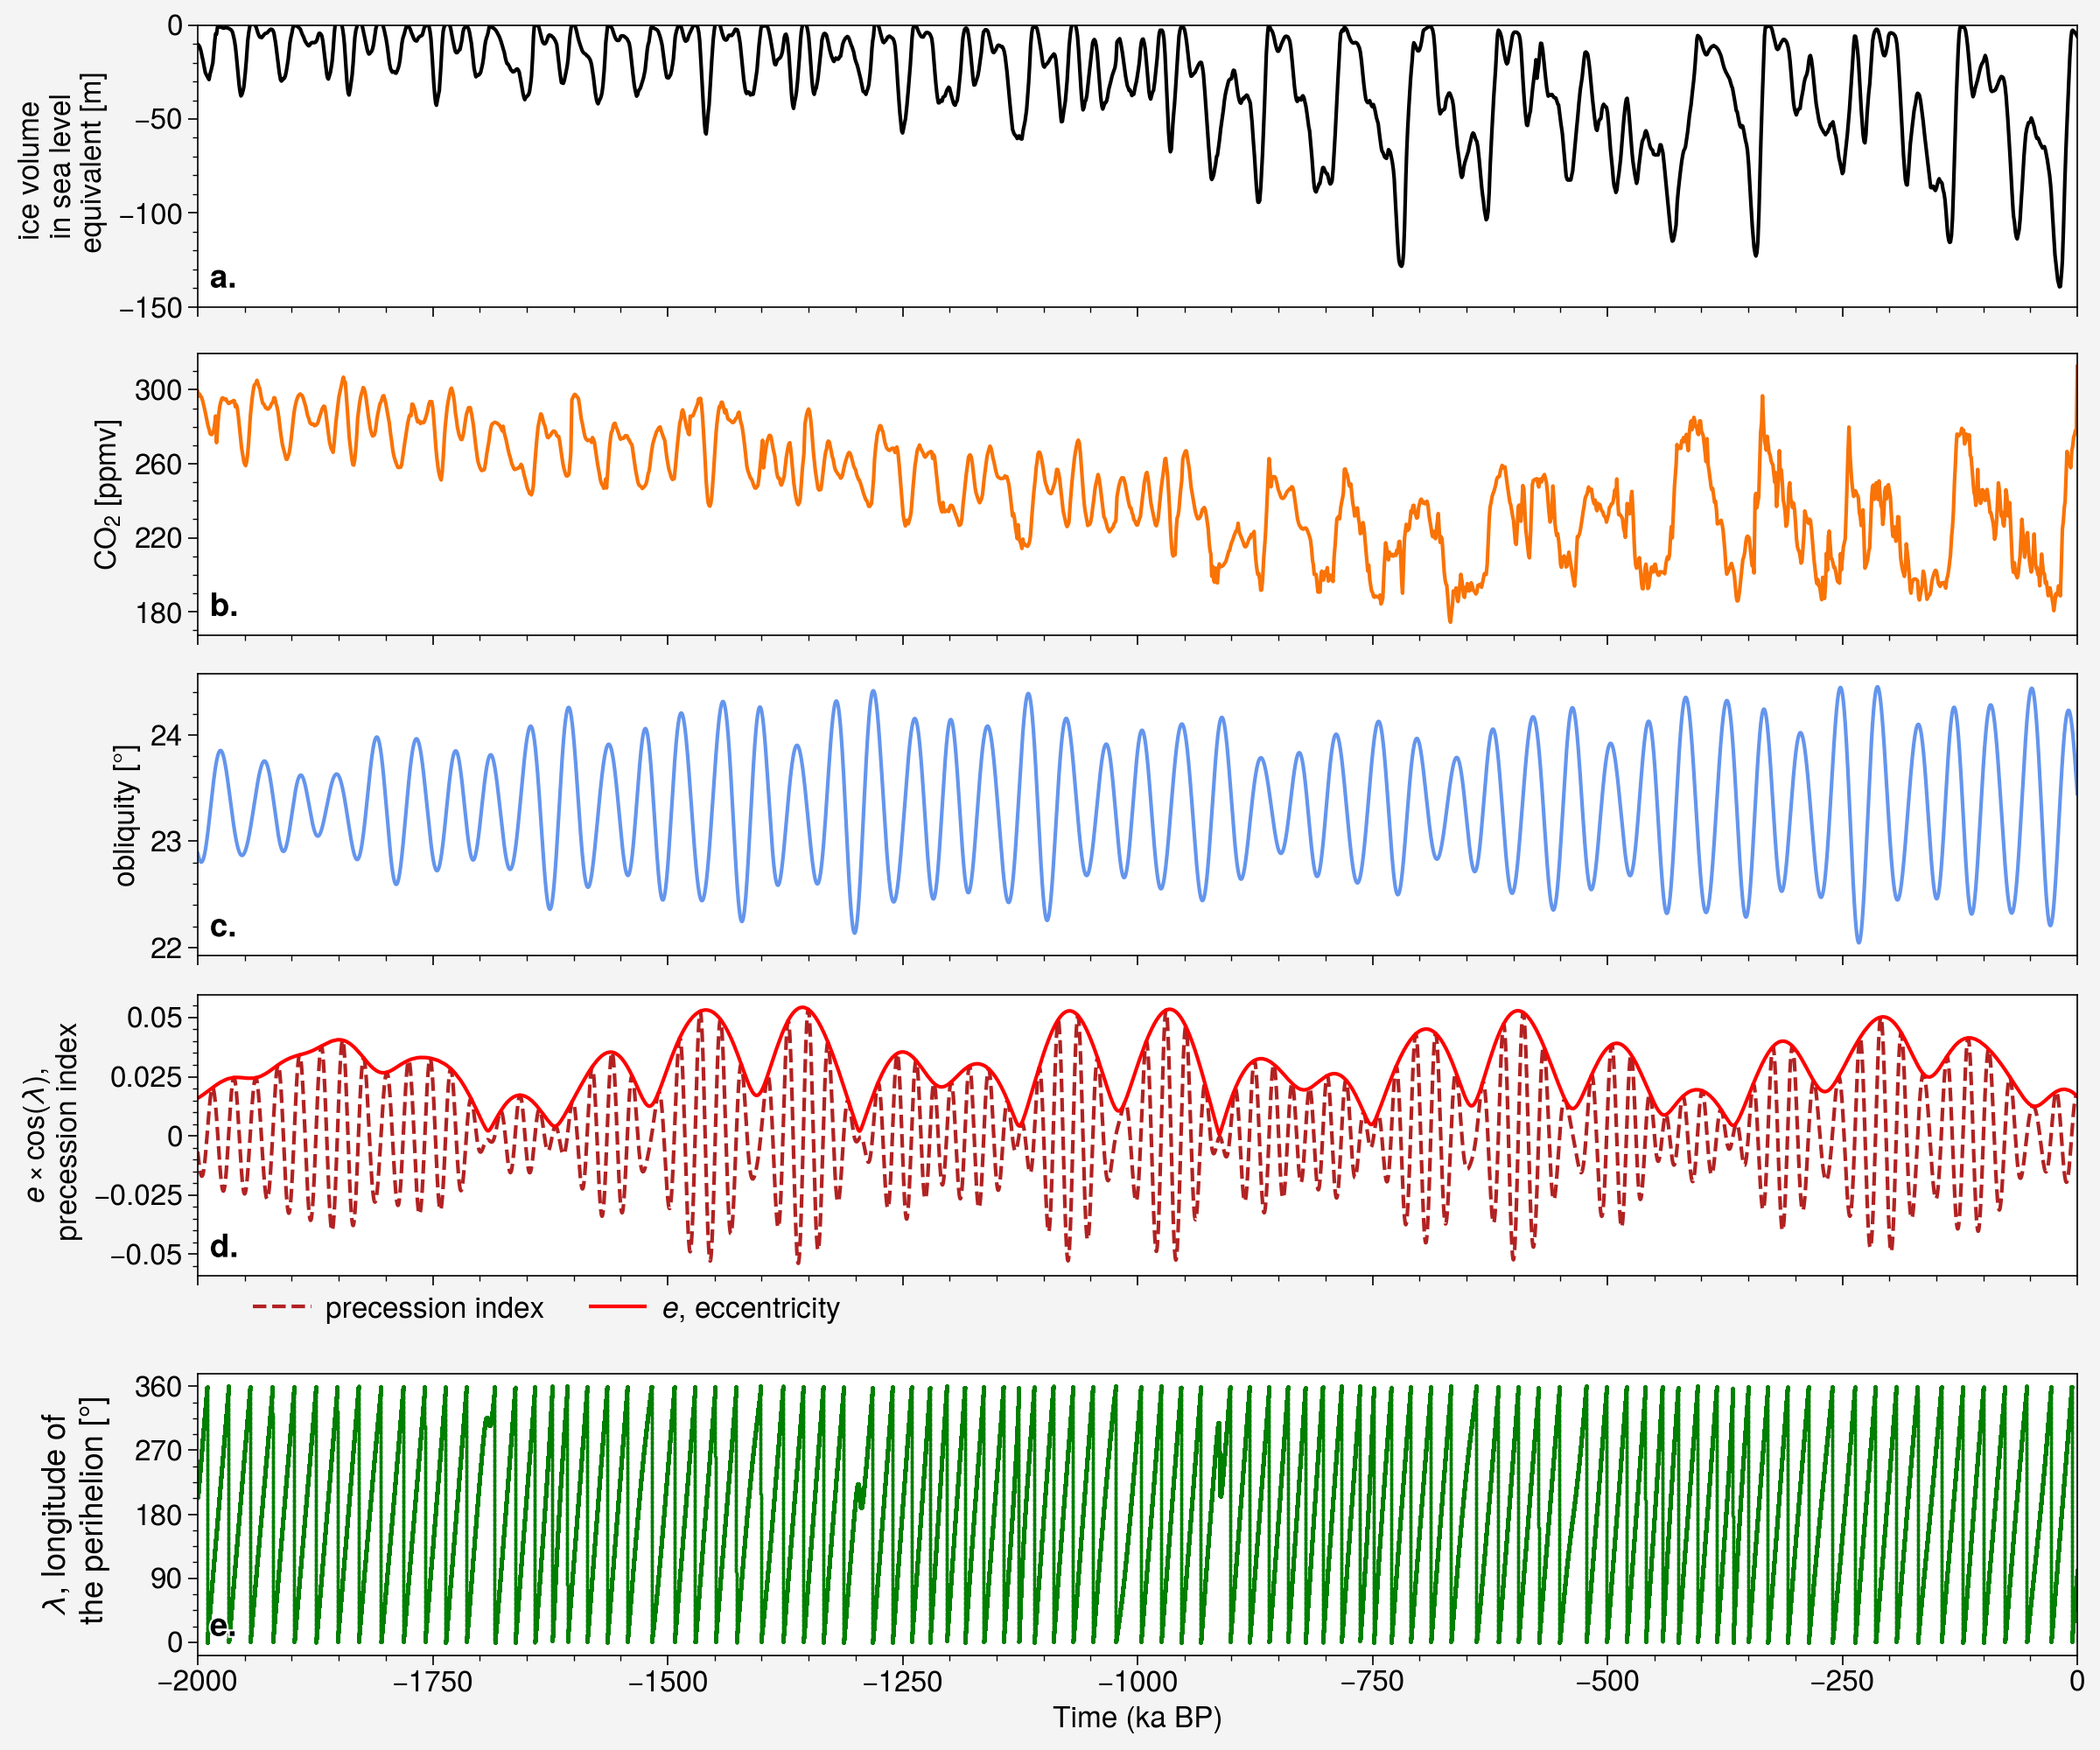

In [12]:
pplt.rc.update(grid=False, titleweight='bold', fontsize=12)

#fig, axs = plt.subplots(5,1,figsize=(12,10))

array = [
    [1, 1],
    [2, 2],
    [3, 3],
    [4, 4],
    [5, 5]
]

fig, axs = pplt.subplots(array, 
                         figsize=(12,10), 
                         #refwidth=13.5, 
                         sharex=True,
                         sharey=False,
                         #refnum=1, refwidth=10
                         )

sle_.plot(ax=axs[0],color='k')
axs[0].format(ylocator= [-150,-100,-50,0], ylim=(-150,0), ylabel='ice volume \n in sea level \n equivalent [m]')

co2_.plot(ax=axs[1],color='orange')
axs[1].format(ylocator=np.arange(180,300+40,40), ylabel=r'CO$_2$ [ppmv]')

params.obliquity.plot(ax=axs[2],color='cornflowerblue')
axs[2].format(ylocator=[22,23,24],ylabel=r'obliquity [°]')

axs[3].plot(params.year, params.precession_index,color='firebrick',linestyle='--',label='precession index')
axs[3].plot(params.year, params.eccentricity,color='red',label=r'$e$, eccentricity')
axs[3].format(ylocator=[-.05,-.025,0,.025,.05],ylabel=r'$e\times \cos(\lambda)$,'+'\n precession index')
axs[3].legend(loc='best',ncol=2,frameon=False,bbox_to_anchor=(0.35,-.014))

axs[4].scatter(params.year,  params.longitude_of_perihelion, c='g', s=.5)
axs[4].set_yticks(np.arange(0,360+90,90))
axs[4].set_yticklabels(np.arange(0,360+90,90),fontsize=12)
axs[4].set_ylabel(r'$\lambda$, longitude of'+'\n the perihelion [°]',fontsize=13,labelpad=10)
        
axs.format(xlocator=np.arange(-2000,0+250,250), xlim=(-2000,0), xlabel='Time (ka BP)', xtickdir='out', ytickdir='out', xtickminor=True, ygridminor=False)

axs.format(abc='a.',abcloc='ll')
        
plt.savefig("/Users/iabdel/Library/CloudStorage/OneDrive-UQAM/Desktop/energy/orbital_params.png", dpi=300, format='png',
    bbox_inches='tight', #pad_inches=.3,
   transparent=True  )

In [28]:
params

<xarray.Dataset> Size: 230MB
Dimensions:                  (year: 4800012)
Coordinates:
  * year                     (year) float64 38MB -2e+03 -2e+03 ... 0.0
Data variables:
    orb_year                 (year) float64 38MB nan nan ... 1.95e+03 1.95e+03
    eccentricity             (year) float64 38MB nan nan nan ... 0.01672 0.01672
    obliquity                (year) float64 38MB nan nan nan ... 23.45 23.45
    longitude_of_perihelion  (year) float64 38MB nan nan nan ... 102.0 102.0
    precession_index         (year) float64 38MB nan nan nan ... 0.01635 0.01635

In [23]:
from matplotlib import patheffects

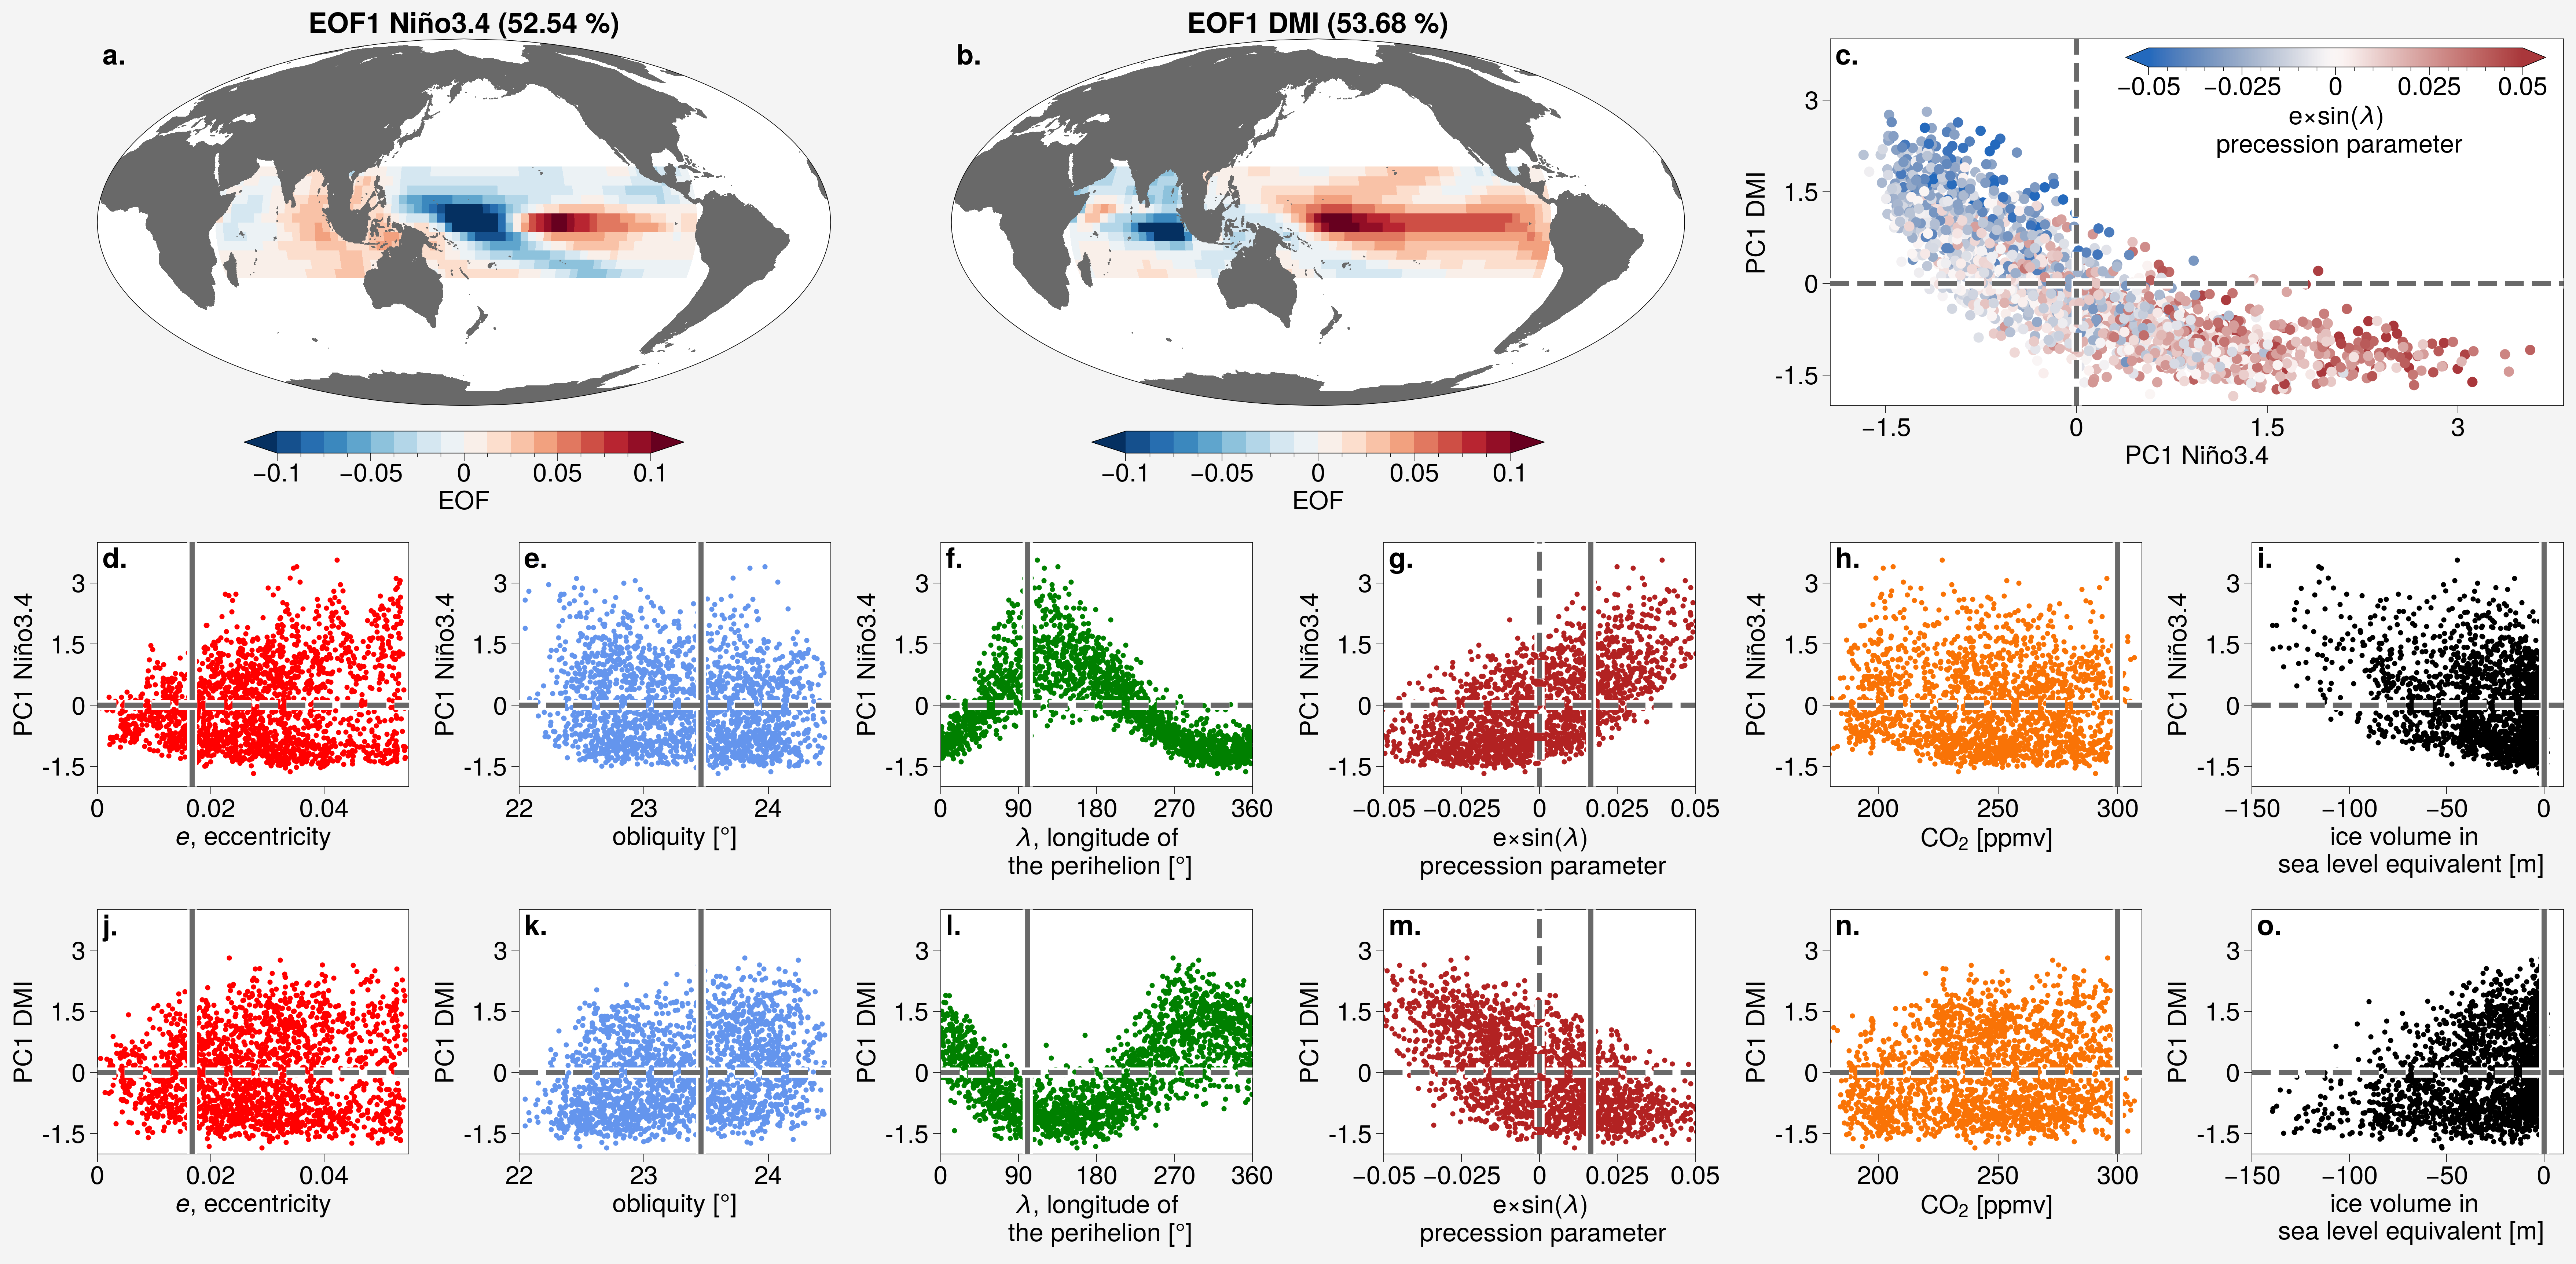

In [ ]:
pplt.rc.update(grid=False, titleweight='bold', fontsize=25)

# Define the layout array
array = [
    [1, 1, 2, 2, 3, 3],
    [4, 5, 6, 7, 8, 9],
    #[6, 6, 6, 6],
    [10, 11, 12, 13, 14, 15],
    #[0, 0, 15, 15, 0, 0]
]

fig, axs = pplt.subplots(array, proj={1: ccrs.Mollweide(central_longitude=165), 2: ccrs.Mollweide(central_longitude=165)}, 
                         #figsize=(30,20), 
                         #refwidth=13.5, 
                         share=False,
                         refnum=1, refwidth=10, hratios=(3, 2, 2)
                         )

axs[2:].format(tickpad=4, xtickdir='out', ytickdir='out', xtickminor=False, ygridminor=False,
                    #titlepad=+2, 
                    ylim = (-2, 4), ylocator = [-1.5, 0, 1.5, 3],
                    ticklen=7.5, yticklabels=['-1.5', '0', '1.5', '3'])

ax_map1 = axs[0]
ax_map2 = axs[1]

min_, max_ = -0.1, 0.1
step = .025 / 2
levels = np.arange(min_, max_ + step, step)

for ax_map, eof, var in zip([ax_map1, ax_map2], 
                            [-eof1_nino34, -eof1_dmi],
                            [var_expl_nino34[0].values * 100, var_expl_dmi[0].values * 100]):

    map_plot = ax_map.pcolor(eof.sel(lon=slice(None,280)).where(mask_array == 2),levels=levels,extend='both')
    
    ax_map.contourf(xr.where(landfrac > .35, landfrac, np.nan), colors='dimgrey')

    if ax_map == ax_map1:
        ax_map.format(title='EOF1 Niño3.4 ({:.2f} %)'.format(var))
    else:
        ax_map.format(title='EOF1 DMI ({:.2f} %)'.format(var))
    
    cbar = ax_map.colorbar(map_plot, loc='b', length=.6,ticks=levels[::4],extend='both', width=0.3,align='center',space=1,
                            label='EOF', ticklen=7.5)

ax_lines = [axs[3], axs[4], axs[5], axs[6], axs[7], axs[8], 
            axs[9], axs[10], axs[11], axs[12], axs[13], axs[14]]

for ax, pcs, n in zip([ax_lines[:6], ax_lines[6:]], [-pc1_nino34, -pc1_dmi], ['Niño3.4', 'DMI']):
    
    s = 10 * 2

    ax[0].scatter(df[2].values[::10][:-1], pcs, c='r', alpha=1, s=s)
    ax[0].axvline(0.0167, linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
    ax[0].format(xlabel= r"$e$, eccentricity", xlim = (0, 0.055), ylabel=f"PC1 {n}")
    ax[0].axhline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])

    ax[1].scatter(df[3].values[::10][:-1], pcs, c='cornflowerblue', alpha=1, s=s)
    ax[1].axvline(23.46, linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
    ax[1].format(xlabel="obliquity [°]", xlim= (22, 24.5), ylabel=f"PC1 {n}")
    ax[1].axhline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])

    ax[2].scatter(df[4].values[::10][:-1], pcs, c='g', alpha=1, s=s)
    ax[2].format(xlabel=r"$\lambda$, longitude of" + "\n the perihelion [°]", xlim=(0, 360),
                xlocator=np.arange(0, 360 + 90, 90), ylabel=f"PC1 {n}")
    ax[2].axvline(abs(280.3 - 180), linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
    ax[2].axhline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])

    ax[3].scatter(df[5].values[::10][:-1], pcs, c='firebrick', alpha=1, s=s)
    ax[3].axvline(0.0167 * np.sin( np.radians(abs(280.3 - 180)) ), linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
    ax[3].format(xlim=([-0.05,0.05]), xlocator=[-0.05, -.025, 0, 0.025, 0.05], 
                xlabel=r"e$\times$sin($\lambda$)" + "\n precession parameter", ylabel=f"PC1 {n}")
    ax[3].axhline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
    ax[3].axvline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])

    ax[4].scatter(co2.values[::10][:-1], pcs, c='orange', alpha=1, s=s)
    ax[4].axvline(300, linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
    ax[4].format(xlim=(180,310), xlabel=r"CO$_2$ [ppmv]", ylabel=f"PC1 {n}")
    ax[4].axhline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])

    ax[5].scatter(sle.values[::10][:-1], pcs, c='k', alpha=1, s=s)
    ax[5].axvline(0, linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
    ax[5].format(xlim=(-150,10), xlabel="ice volume in \n sea level equivalent [m]", ylabel=f"PC1 {n}")
    ax[5].axhline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])

######################################

ax_scatter = axs[2]
im = ax_scatter.scatter(-pc1_nino34, -pc1_dmi, c=df[5].values[::10][:-1], 
                        vmin=-0.05,vmax=0.05,
                        #s=abs(df[5].values[::10][:-1]), 
                        #smin=50, smax=50,
                        s=2**6.5,
                        marker="o",
                        cmap="Vlag",colorbar='ur', extend='both',
                        colorbar_kw={'align' : 'center',#'space' : 3, 
                        'length': 16.5, 'width' : 1.5, 
                        'extend' : 'both', 'ticks': [-0.05, -.025, 0, 0.025, 0.05],
                        'label' :  r"e$\times$sin($\lambda$)" + "\n precession parameter", 'ticklen' : 7.5,
                        'frame' : False})

#ax_scatter.tick_params(width=3, pad=15, length=10)
ax_scatter.axvline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5, 
path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
ax_scatter.axhline(0, linestyle='--', color='dimgrey', alpha=1, zorder=10, linewidth=5,
path_effects=[patheffects.withStroke(linewidth=10, foreground="w")])
ax_scatter.format(ylocator=[-1.5, 0, 1.5, 3], xlocator = [-1.5, 0, 1.5, 3], xlabel='PC1 Niño3.4',ylabel='PC1 DMI')

######################################

axs.format(abc='a.',abcloc='ul') 

######################################

plt.savefig("/Users/iabdel/Library/CloudStorage/OneDrive-UQAM/Desktop/energy/pc_nino34_dmi.png", dpi=300, format='png',
    bbox_inches='tight', #pad_inches=.3,
   transparent=True  )

## Present day 

In [36]:
cobe = xr.open_dataset('variables/sst_cobe.nc',).sst
cobe = cobe.sel(time=slice('1950-01-01','2019-12-01'))

In [37]:
ersstv5 = xr.open_dataset('variables/ersstv5.nc').sst
ersstv5 = ersstv5.sel(time=slice('1950-01-01','2019-12-01'))

In [38]:
dmi_cesm = DMI_idx(temp_adj[-50*12:] - 273.15)
nino34_cesm = NINO34_idx(temp_adj[-50*12:] - 273.15)
sst_cesm = anom(temp_adj[-50*12:] - 273.15)

_,_,slope_dmi_cesm,_,_,_ = lag_linregress_3D(dmi_cesm, sst_cesm, lagx=0, lagy=0) 

_,_,slope_nino34_cesm,_,_,_ = lag_linregress_3D(nino34_cesm, sst_cesm, lagx=0, lagy=0) 

In [39]:
dmi_cobe = DMI_idx(cobe)
nino34_cobe = NINO34_idx(cobe)
sst_cobe = anom(cobe)

_,_,slope_dmi_cobe,_,_,_ = lag_linregress_3D(dmi_cobe, sst_cobe, lagx=0, lagy=0) 

_,_,slope_nino34_cobe,_,_,_ = lag_linregress_3D(nino34_cobe, sst_cobe, lagx=0, lagy=0) 

In [40]:
dmi_ersstv5 = DMI_idx(ersstv5)
nino34_ersstv5 = NINO34_idx(ersstv5)
sst_ersstv5 = anom(ersstv5)

_,_,slope_dmi_ersstv5,_,_,_ = lag_linregress_3D(dmi_ersstv5, sst_ersstv5, lagx=0, lagy=0) 

_,_,slope_nino34_ersstv5,_,_,_ = lag_linregress_3D(nino34_ersstv5, sst_ersstv5, lagx=0, lagy=0) 

In [42]:
eio_cobe = EIO(cobe)
wio_cobe = WIO(cobe)
dmi_cobe = DMI(cobe)
nino34_cobe = NINO34(cobe)

In [43]:
eio_ersstv5 = EIO(ersstv5)
wio_ersstv5 = WIO(ersstv5)
dmi_ersstv5 = DMI(ersstv5)
nino34_ersstv5 = NINO34(ersstv5)

In [44]:
eio_cesm = EIO(temp_adj[-50*12:] - 273.15)
wio_cesm = WIO(temp_adj[-50*12:] - 273.15)
dmi_cesm = DMI(temp_adj[-50*12:] - 273.15)
nino34_cesm = NINO34(temp_adj[-50*12:] - 273.15)

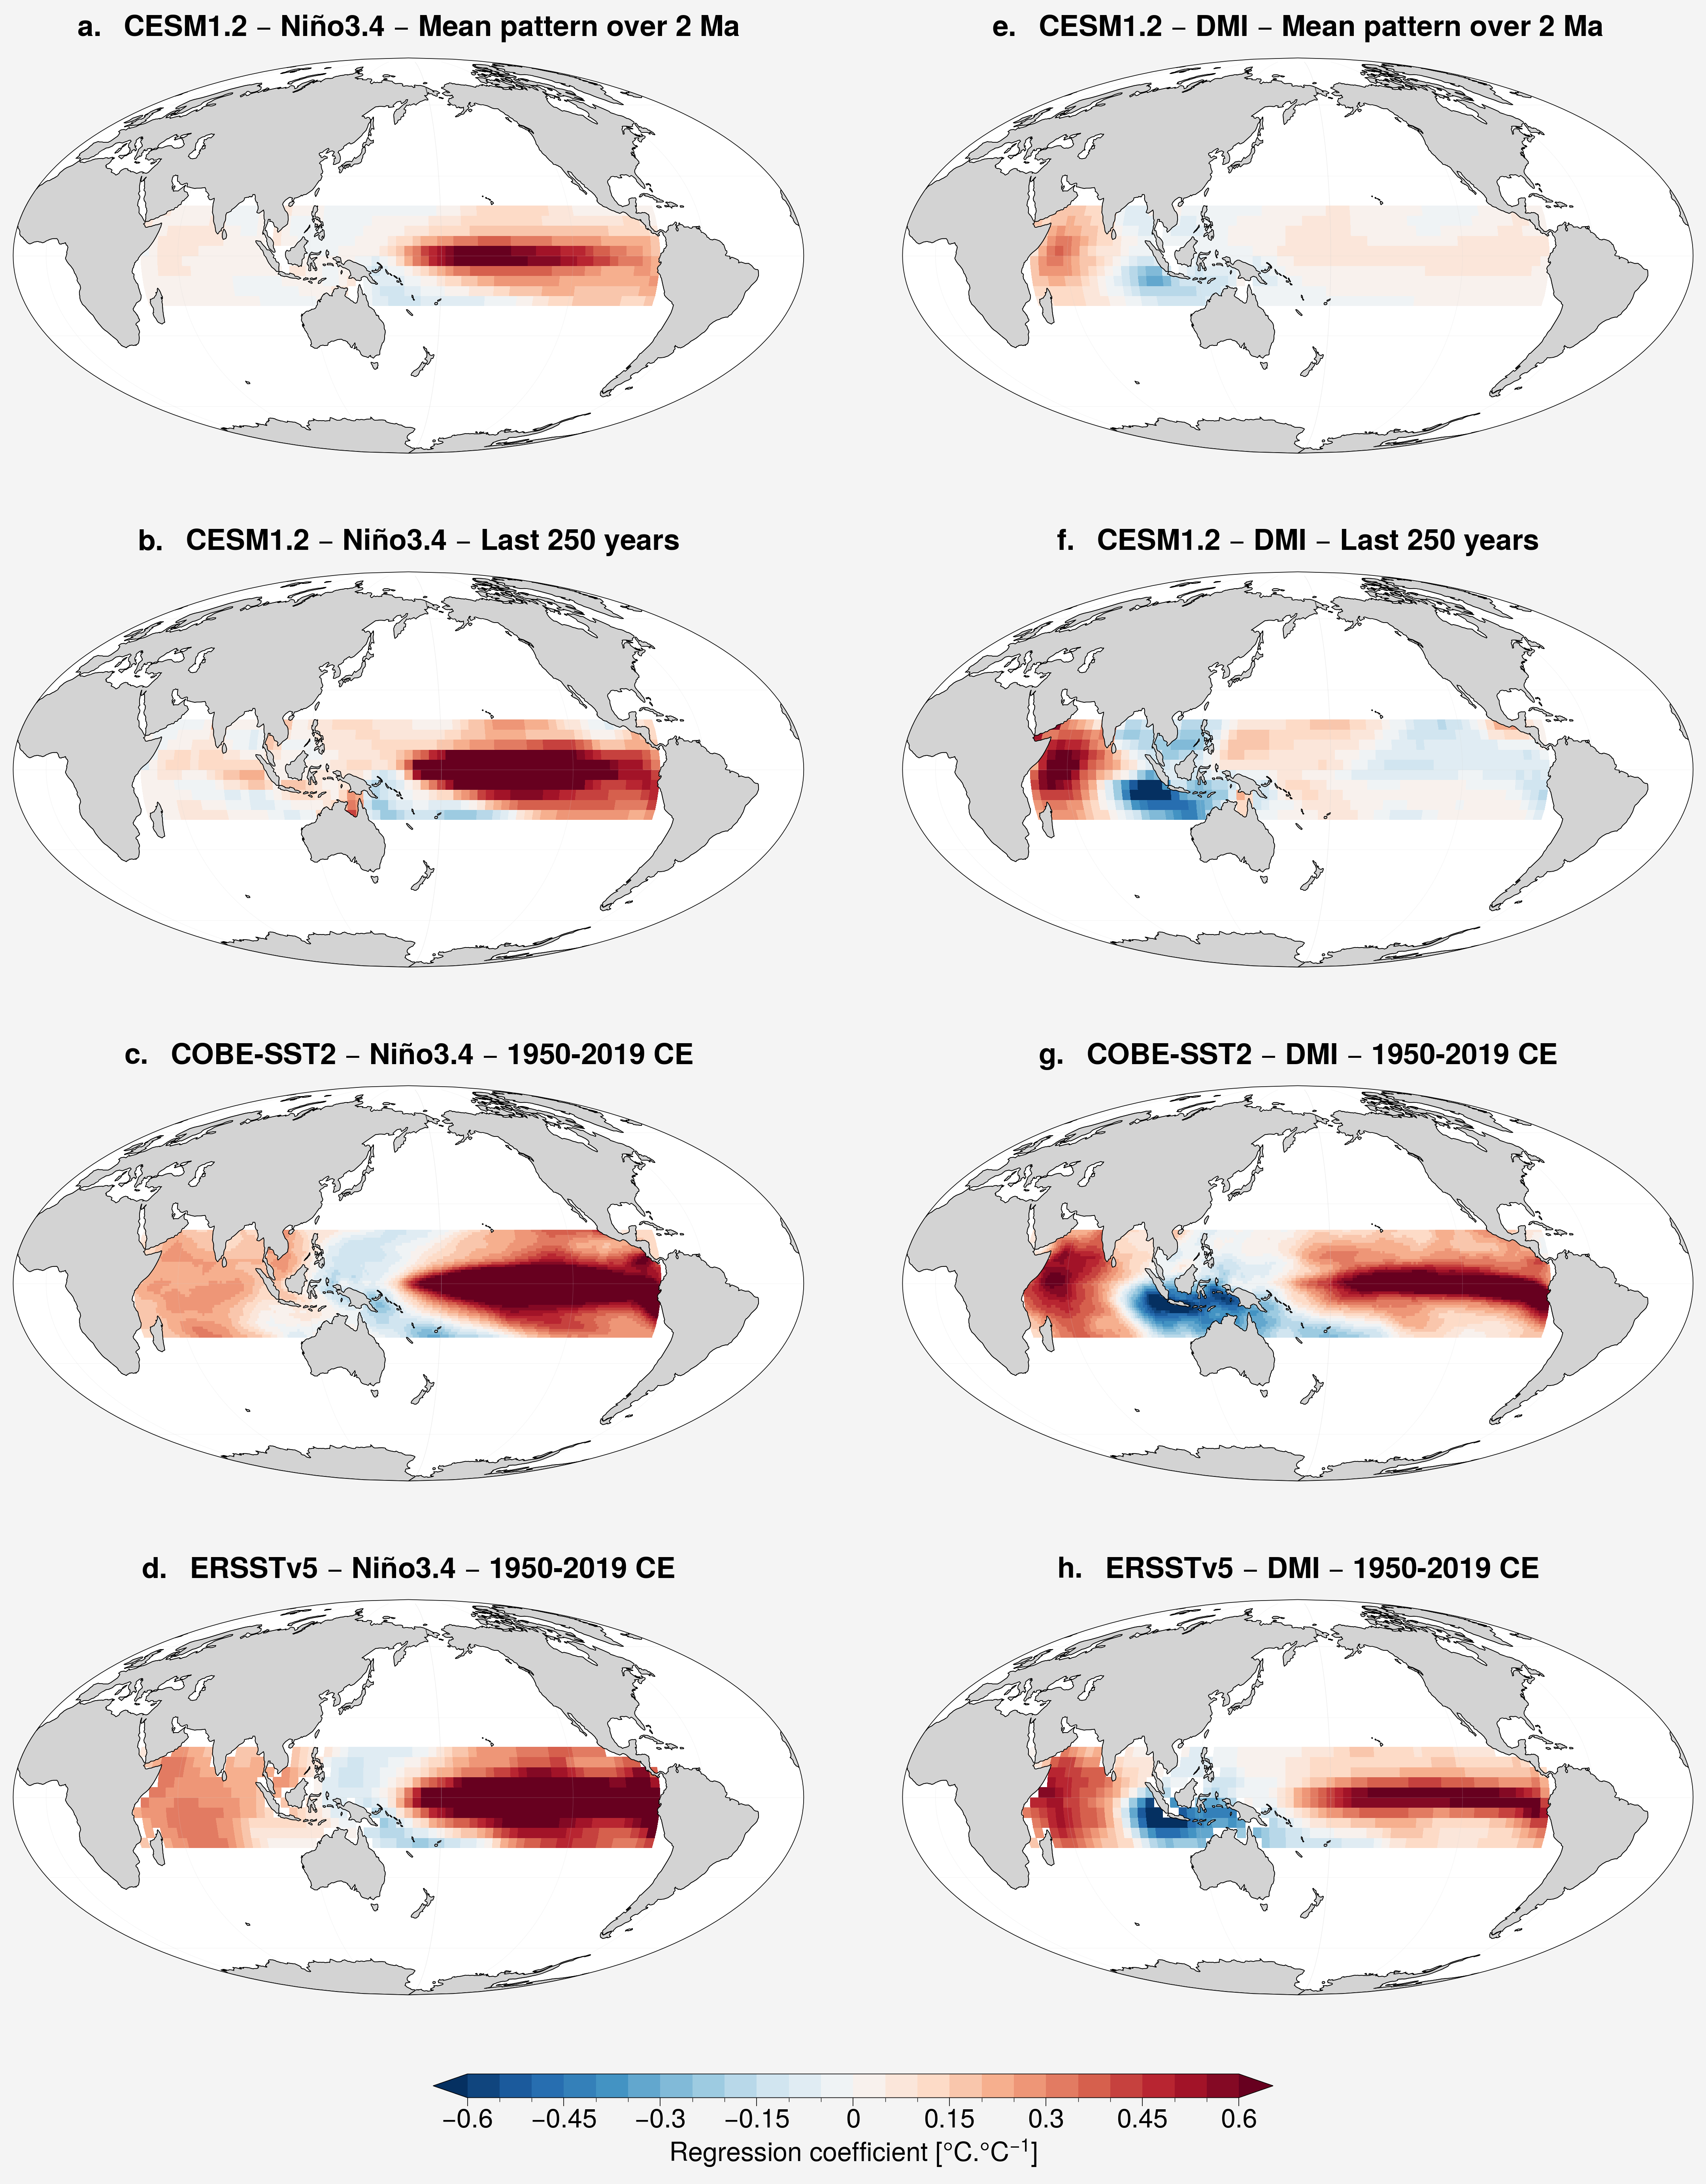

In [134]:
pplt.rc.update(grid=False, titleweight='bold', fontsize=24)

# Define the layout array
array = [
    [1, 5],
    [2, 6],
    [3, 7],
    [4, 8],
]

fig, axs = pplt.subplots(array, proj={1: ccrs.Mollweide(central_longitude=165), 2: ccrs.Mollweide(central_longitude=165), 3: ccrs.Mollweide(central_longitude=165), 4: ccrs.Mollweide(central_longitude=165),
                                    5: ccrs.Mollweide(central_longitude=165), 6: ccrs.Mollweide(central_longitude=165), 7: ccrs.Mollweide(central_longitude=165), 8: ccrs.Mollweide(central_longitude=165)},
                         #figsize=(20,10), 
                         #refwidth=13.5, 
                         share=False,
                         refnum=1, refwidth=10,
                         wspace=3.75, hspace=4.5
                         )

for i, ds in enumerate([ds_slopes_nino34.mean(dim='time').slopes ,slope_nino34_cesm, slope_nino34_cobe,slope_nino34_ersstv5,
                        ds_slopes_dmi.mean(dim='time').slopes, slope_dmi_cesm, slope_dmi_cobe,slope_dmi_ersstv5]):
    ax = axs[i]
    
    #ax.set_extent([50, 300, -20, 20], ccrs.PlateCarree())

    e = 0.05
    vmax = 0.6
    vmin = -0.6

    levels = np.arange(vmin, vmax + e, e)
    cmap = 'RdBu_r'

    if ds.lat[0] < 0 :
        im = ds.sel(lon=slice(40,280),lat=slice(-20,20)).plot.pcolormesh(ax=ax, levels=levels, extend="both",
                                        vmin=vmin, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)
    else:
        im = ds.sel(lon=slice(40,280),lat=slice(20,-20)).plot.pcolormesh(ax=ax, levels=levels, extend="both",
                                        vmin=vmin, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor="k", zorder=1)

    ax.set_xlabel('')
    ax.set_ylabel('')

    if i == 0:
        ax.set_title('CESM1.2 $-$ Niño3.4 $-$ Mean pattern over 2 Ma')
    if i == 1:
        ax.set_title('CESM1.2 $-$ Niño3.4 $-$ Last 250 years')
    if i == 2:
        ax.set_title('COBE-SST2 $-$ Niño3.4 $-$ 1950-2019 CE')
    if i == 3:
        ax.set_title('ERSSTv5 $-$ Niño3.4 $-$ 1950-2019 CE')
    if i == 4:
        ax.set_title('CESM1.2 $-$ DMI $-$ Mean pattern over 2 Ma')
    if i == 5:
        ax.set_title('CESM1.2 $-$ DMI $-$ Last 250 years')
    if i == 6:
        ax.set_title('COBE-SST2 $-$ DMI $-$ 1950-2019 CE')
    if i == 7:
        ax.set_title('ERSSTv5 $-$ DMI $-$ 1950-2019 CE')
        
    ax.tick_params(axis="y", direction='out', length=8)
    ax.tick_params(axis="x", direction='out', length=8)
    ax.gridlines(color='lightgray', alpha=0.2, linewidth=0.5)
    

axs.format(abc='a.',abcloc='c',titleloc='c',titlepad=20,abctitlepad=20) 

fig.colorbar(im, label='Regression coefficient [°C.°C$^{-1}$]', ticks=levels[::3], loc='b', extend ='both', ticklen = 7.5,
                length=.5, width=0.3, align='center', space=3)

plt.savefig("/Users/iabdel/Library/CloudStorage/OneDrive-UQAM/Desktop/energy/reg_compar.png", dpi=300, format='png',
    bbox_inches='tight', #pad_inches=.3,
   transparent=True  )


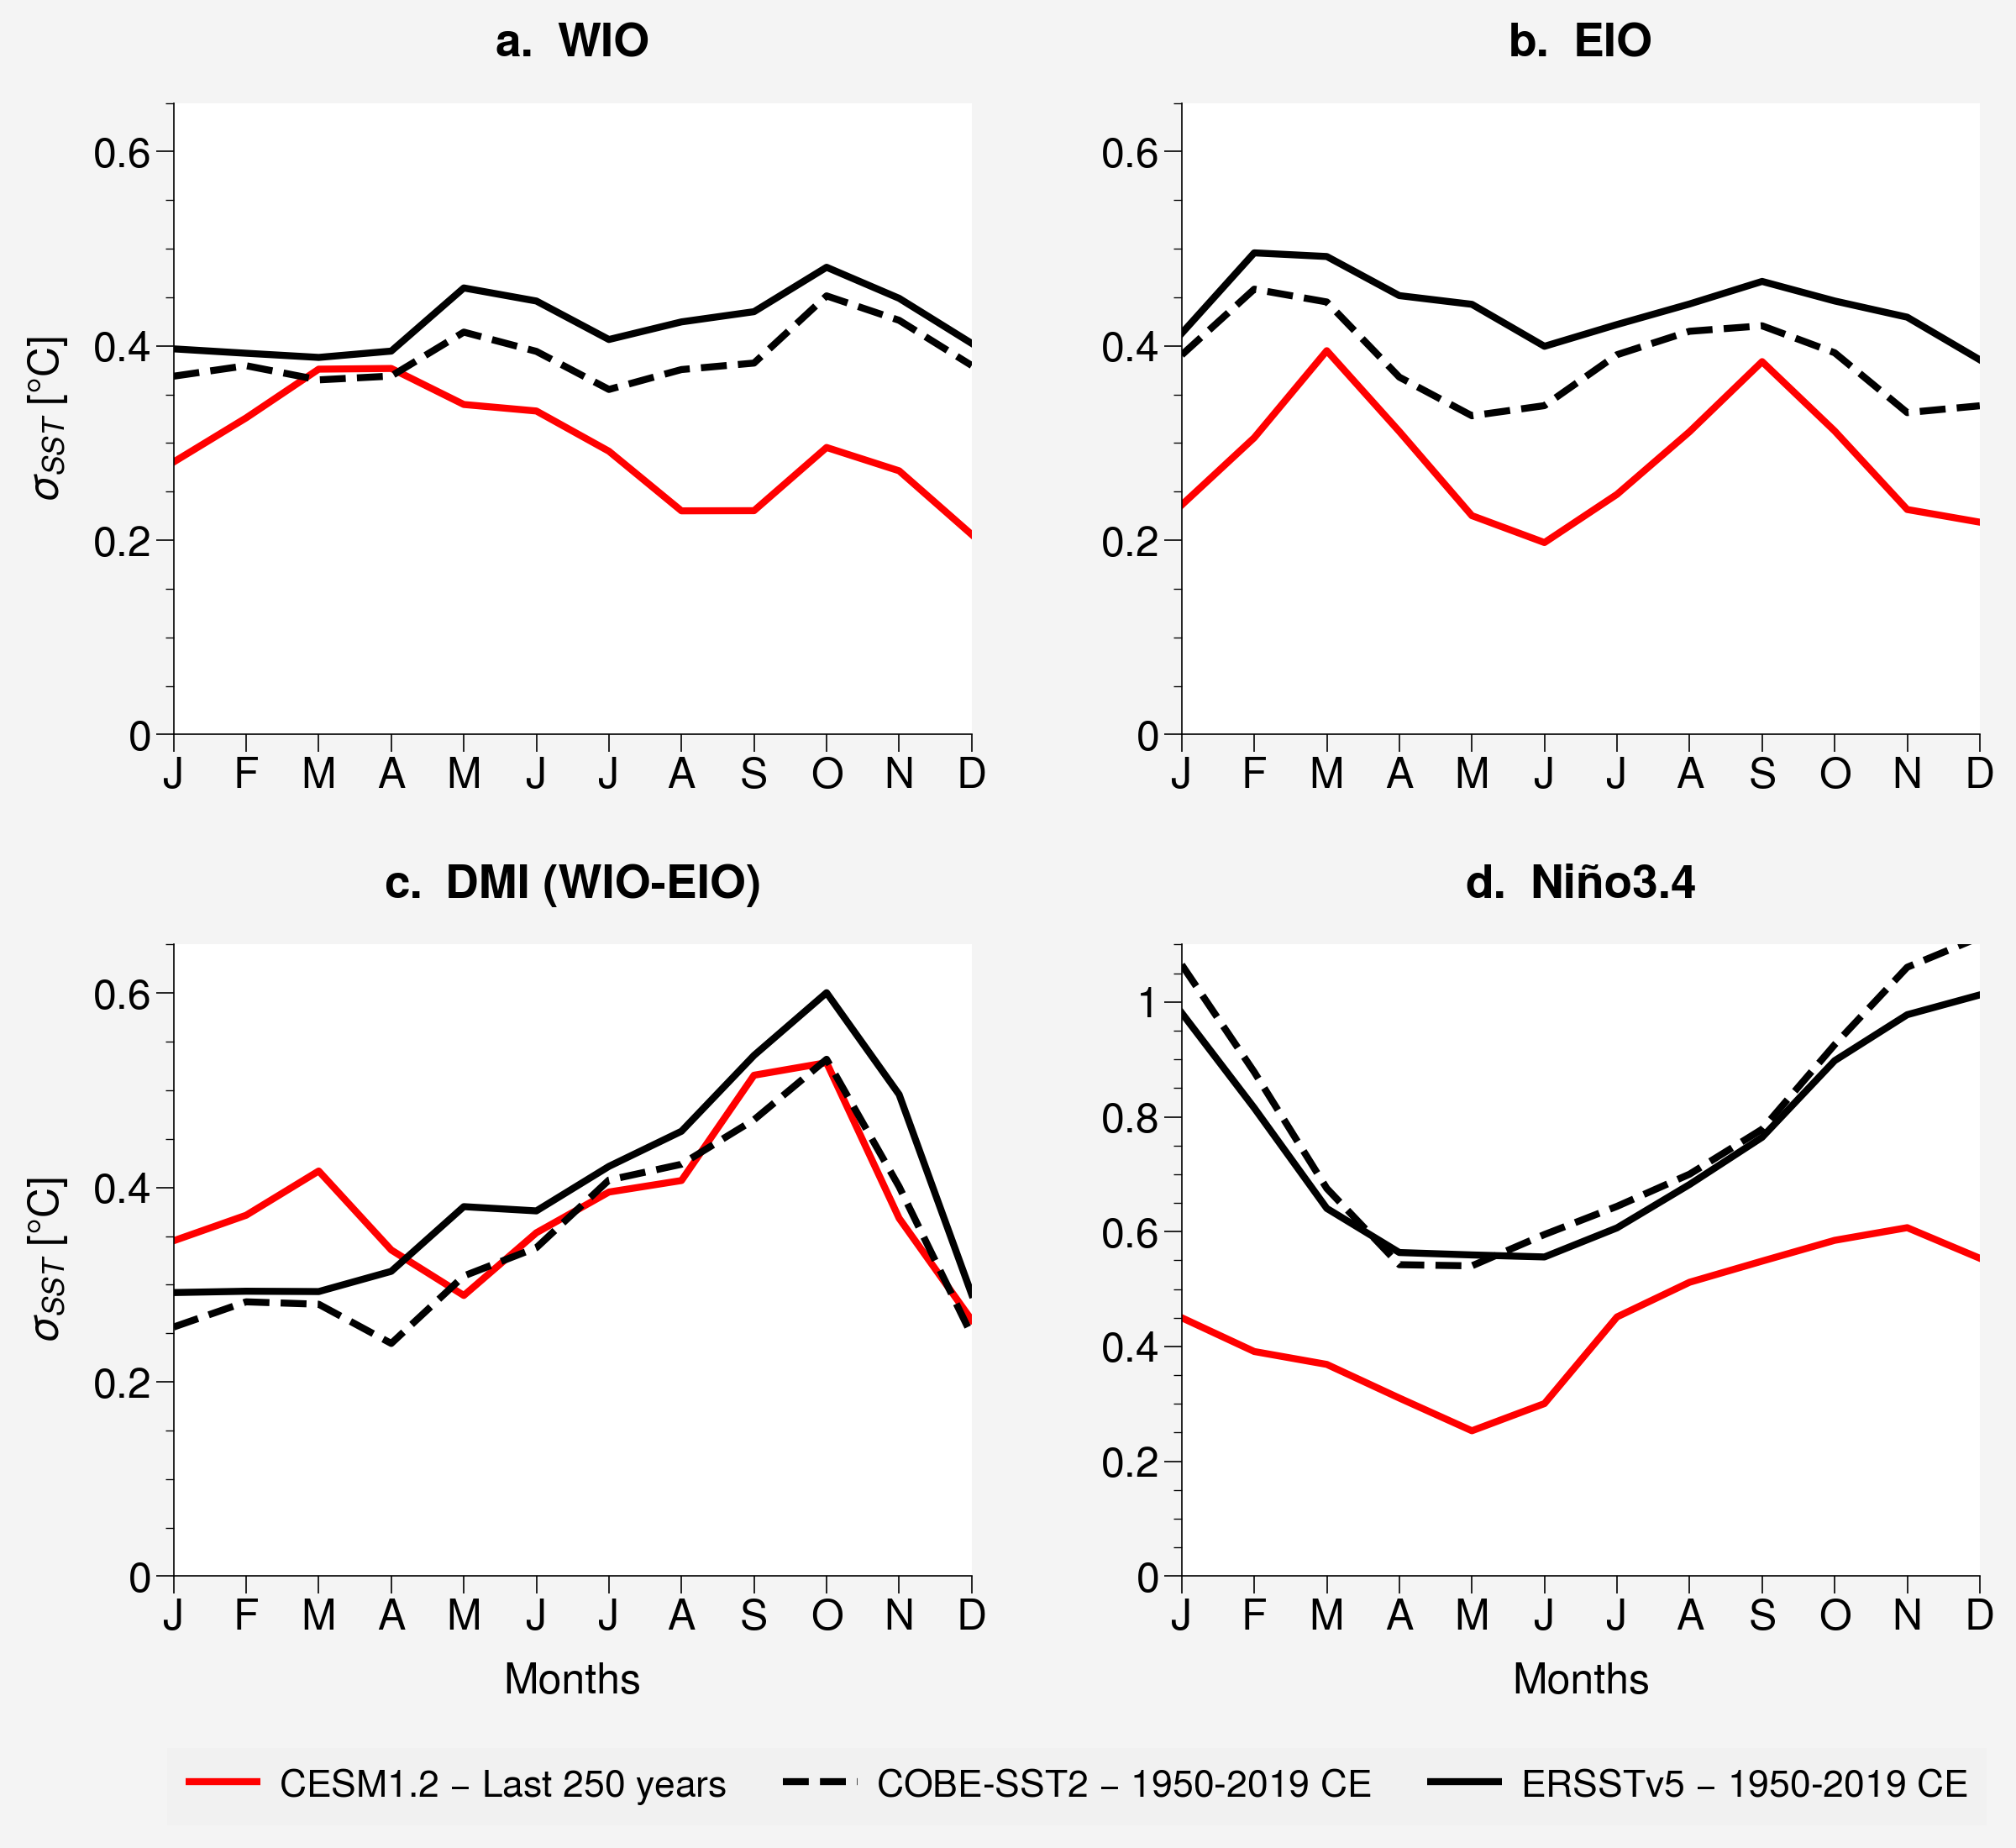

In [20]:
pplt.rc.update(grid=False, titleweight='bold', fontsize=18)

# Define the layout array
array = [
    [1, 2],
    [3, 4]
]

fig, axs = pplt.subplots(array,
                        figsize=(12,11), 
                         #refwidth=13.5, 
                         share=False,
                         hspace=5,wspace=5
                         )

for wio,eio,iod,nino34,c in zip([wio_cesm,wio_cobe,wio_ersstv5
                                   ],
                                  [eio_cesm,eio_cobe, eio_ersstv5
                                  ],
                                  [dmi_cesm,dmi_cobe, dmi_ersstv5],
                                  [nino34_cesm,nino34_cobe,nino34_ersstv5
                                  ],
                                  ['r','k','k']):
    
    if nino34[0] == nino34_cobe[0]:
        linestyle = '--'
    else:
        linestyle = '-'

    (wio.\
    groupby('time.month').std()).plot(ax=axs[0],c=c,linestyle=linestyle,linewidth=3)

    (eio.\
    groupby('time.month').std()).plot(ax=axs[1],c=c,linestyle=linestyle,linewidth=3)
    
    (iod.\
    groupby('time.month').std()).plot(ax=axs[2],c=c,linestyle=linestyle,linewidth=3)

    (nino34.\
    groupby('time.month').std()).plot(ax=axs[3],c=c,linestyle=linestyle,linewidth=3)


axs[0].set_title('WIO',pad=15)
axs[1].set_title('EIO',pad=15)
axs[2].set_title('DMI (WIO-EIO)',pad=15)
axs[3].set_title('Niño3.4',pad=15)

for i,ax in enumerate(axs):
        
    ax.set_xlim(1,12)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

    ax.grid(False)

    ax.spines[['top','right']].set_visible(False)

    if (ax == axs[0]) or (ax == axs[2]):
        ax.set_ylabel(r'$\sigma_{SST}$ [°C]',labelpad=10)
    else:
        ax.set_ylabel('')

    if (ax == axs[2]) or (ax == axs[3]):
        ax.set_xlabel('Months',labelpad=10)
    else:
        ax.set_xlabel('')

    if i == 3:
        ax.set_ylim(0,1.1)
        ax.set_yticks([0,.2,.4,.6,0.8, 1])    
    else :
        ax.set_ylim(0,0.65)
        ax.set_yticks([0,.2,.4,.6])

legend_elements = [Line2D([0], [0], linewidth=3, color='r',label='CESM1.2 $-$ Last 250 years'),
                  Line2D([0], [0], linewidth=3, color='k',linestyle='--',label='COBE-SST2 $-$ 1950-2019 CE'),
                  Line2D([0], [0], linewidth=3, color='k',label='ERSSTv5 $-$ 1950-2019 CE')]


legend = fig.legend(handles=legend_elements, ncol=3, labelspacing=.45, fontsize=16,
                 loc='bottom')

legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.01))
legend.get_frame().set_linewidth(0.0)

axs.format(abc='a.',abcloc='c', titleloc='c', titlepad=20,abctitlepad=10, 
xtickdir='out', ytickdir='out', xtickminor=False, ygridminor=False, ticklen=7.5) 

plt.savefig(f"/Users/iabdel/Library/CloudStorage/OneDrive-UQAM/Desktop/energy/cesm12.szn_std_last50.png", dpi=300, format='png',
    bbox_inches='tight', pad_inches=.3,
    transparent=True
   )

plt.show()

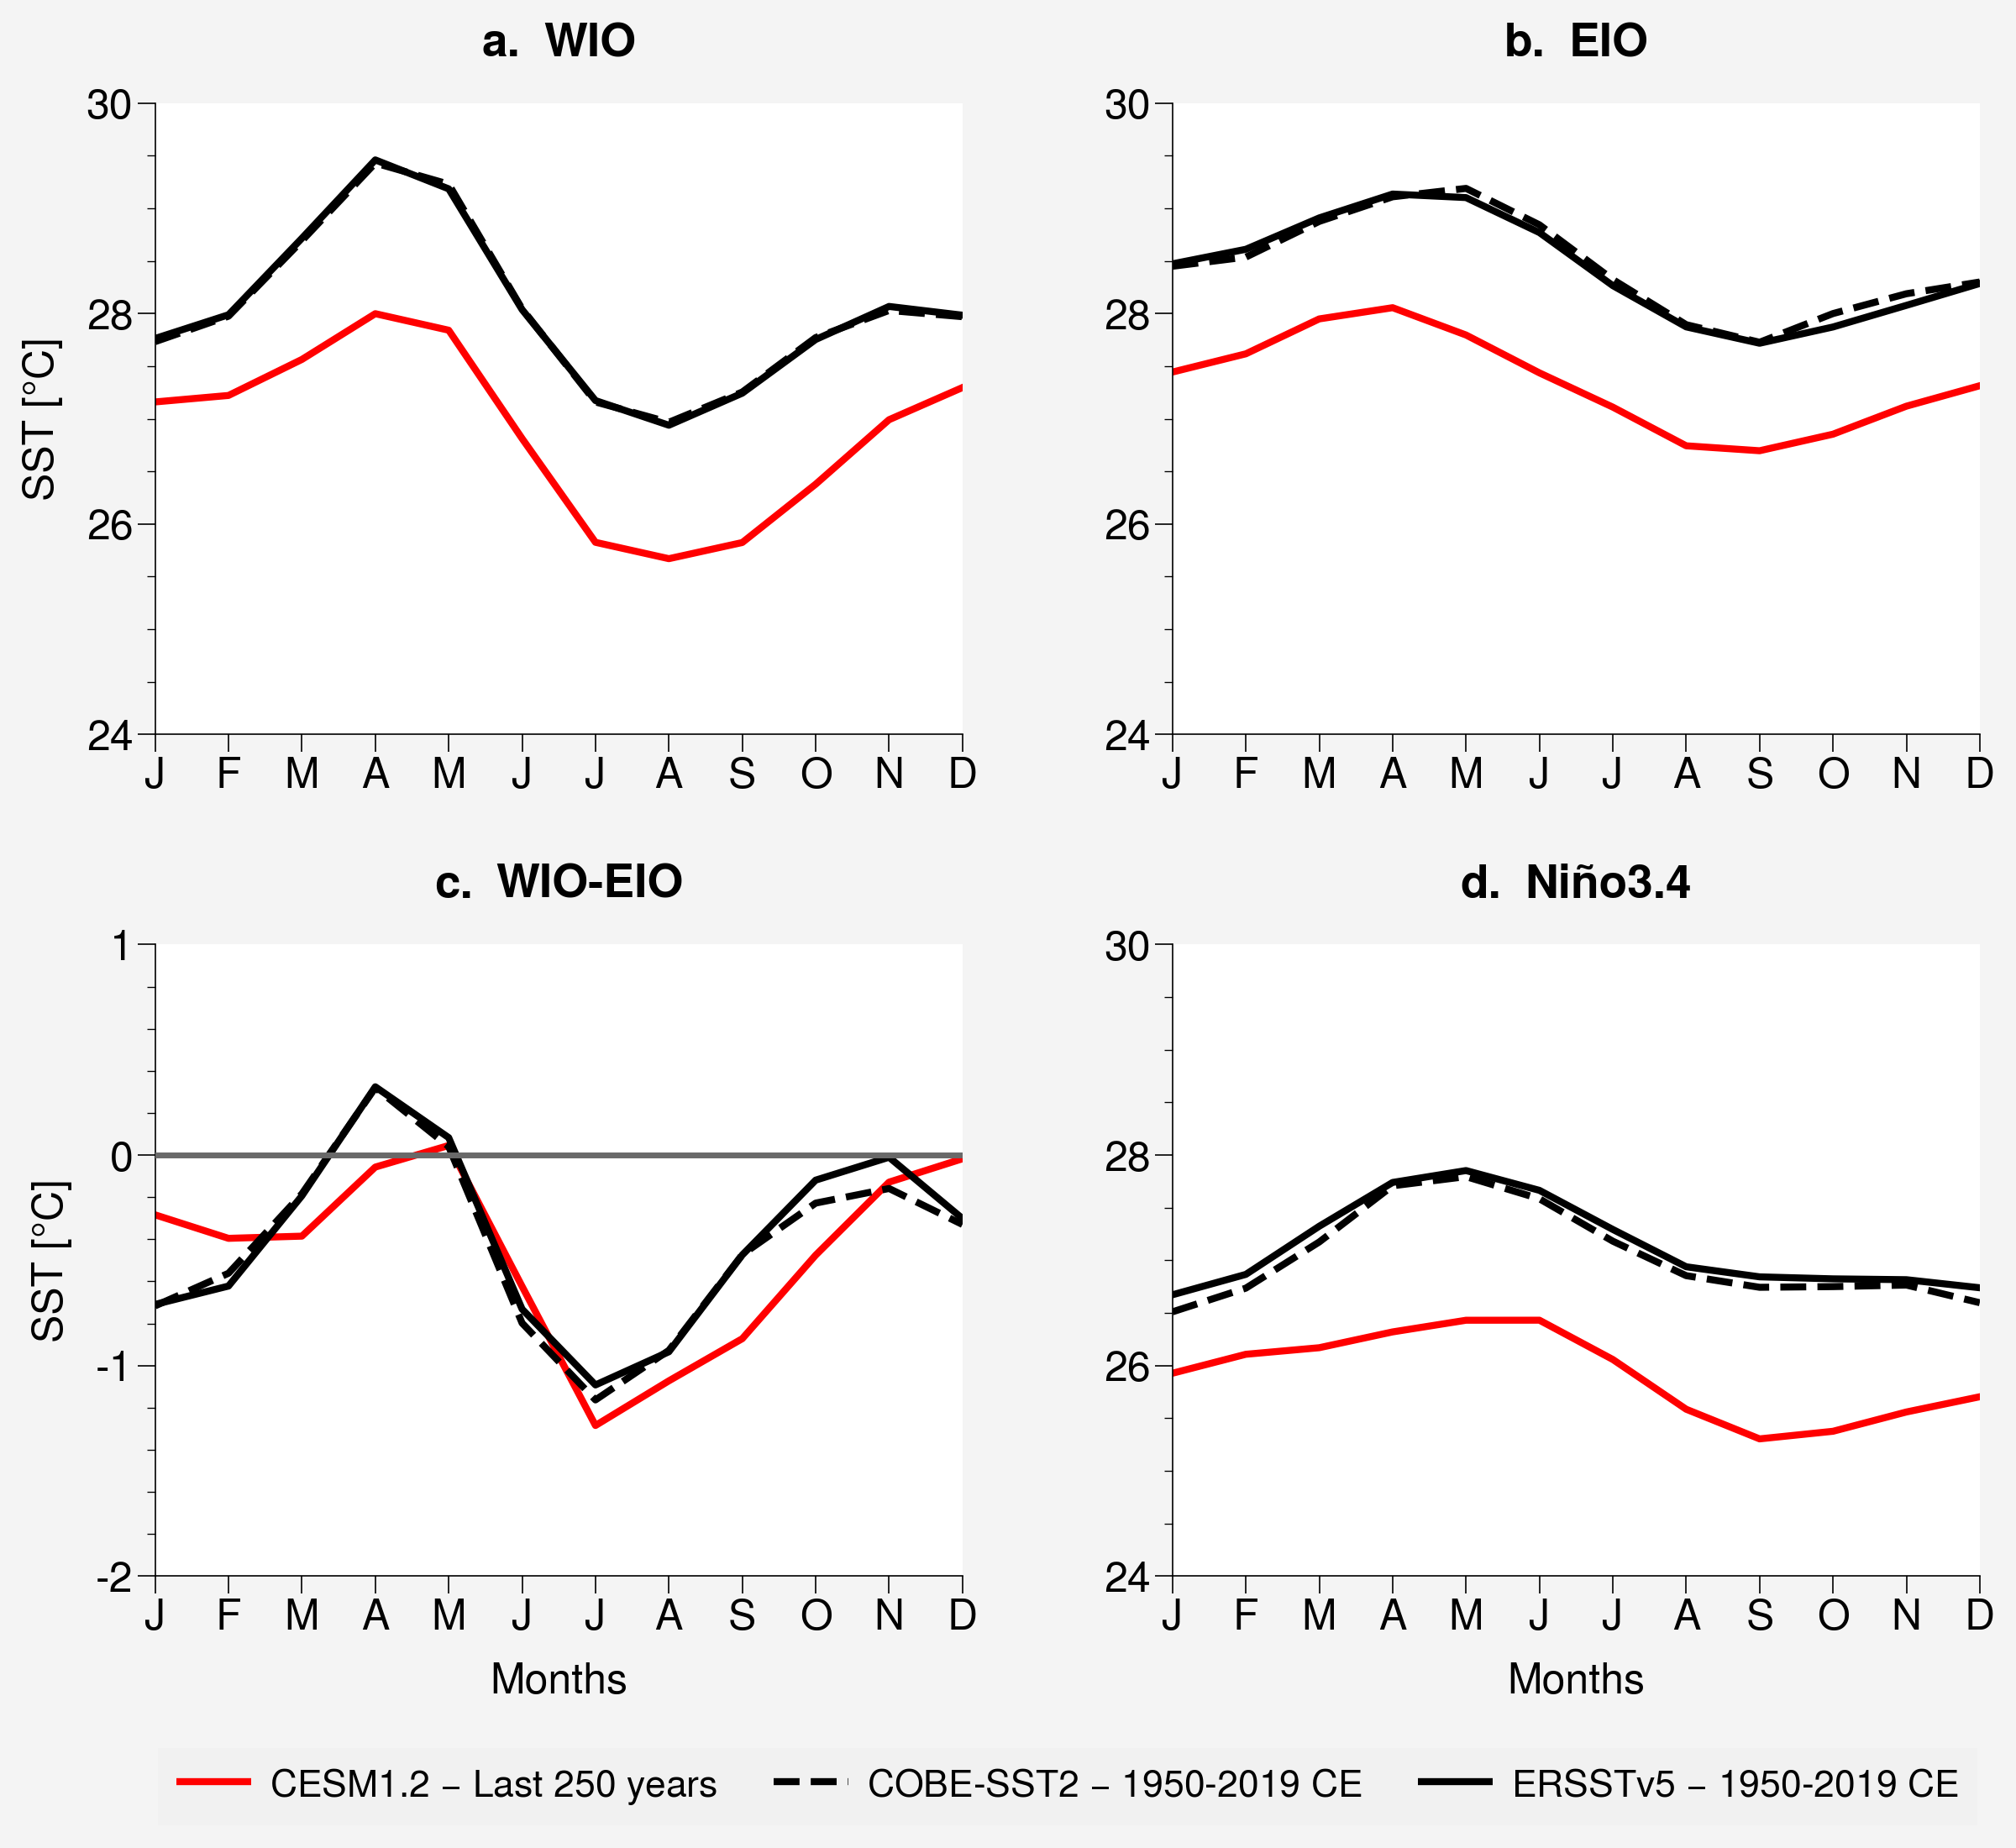

In [21]:
pplt.rc.update(grid=False, titleweight='bold', fontsize=18)

# Define the layout array
array = [
    [1, 2],
    [3, 4]
]

fig, axs = pplt.subplots(array,
                        figsize=(12,11), 
                         #refwidth=13.5, 
                         share=False,
                         hspace=5,wspace=5
                         )

for wio,eio,iod,nino34,c in zip([wio_cesm,wio_cobe,wio_ersstv5
                                   ],
                                  [eio_cesm,eio_cobe, eio_ersstv5
                                  ],
                                  [dmi_cesm,dmi_cobe, dmi_ersstv5],
                                  [nino34_cesm,nino34_cobe,nino34_ersstv5
                                  ],
                                  ['r','k','k']):
    
    if nino34[0] == nino34_cobe[0]:
        linestyle = '--'
    else:
        linestyle = '-'

    (wio.\
    groupby('time.month').mean()).plot(ax=axs[0],c=c,linestyle=linestyle,linewidth=3)

    (eio.\
    groupby('time.month').mean()).plot(ax=axs[1],c=c,linestyle=linestyle,linewidth=3)
    
    (iod.\
    groupby('time.month').mean()).plot(ax=axs[2],c=c,linestyle=linestyle,linewidth=3)

    (nino34.\
    groupby('time.month').mean()).plot(ax=axs[3],c=c,linestyle=linestyle,linewidth=3)


axs[0].set_title('WIO',pad=15)
axs[1].set_title('EIO',pad=15)
axs[2].set_title('WIO-EIO',pad=15)
axs[3].set_title('Niño3.4',pad=15)

for i,ax in enumerate(axs):
        
    ax.set_xlim(1,12)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

    ax.grid(False)

    ax.spines[['top','right']].set_visible(False)

    if (ax == axs[0]) or (ax == axs[2]):
        ax.set_ylabel(r'SST [°C]',labelpad=10)
    else:
        ax.set_ylabel('')

    if (ax == axs[2]) or (ax == axs[3]):
        ax.set_xlabel('Months',labelpad=10)
    else:
        ax.set_xlabel('')

    if ax == axs[2]:
        ax.set_ylim(-2,1)
        ax.set_yticks([-2,-1,0,1])
        ax.set_yticklabels([-2,-1,0,1])
        ax.axhline(0, linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=2.5)


    else:
        ax.set_ylim(24,30)
        ax.set_yticks([24,26,28,30])
        ax.set_yticklabels([24,26,28,30])

legend_elements = [Line2D([0], [0], linewidth=3, color='r',label='CESM1.2 $-$ Last 250 years'),
                  Line2D([0], [0], linewidth=3, color='k',linestyle='--',label='COBE-SST2 $-$ 1950-2019 CE'),
                  Line2D([0], [0], linewidth=3, color='k',label='ERSSTv5 $-$ 1950-2019 CE')]


legend = fig.legend(handles=legend_elements, ncol=3, labelspacing=.45, fontsize=16,
                 loc='bottom')

legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.01))
legend.get_frame().set_linewidth(0.0)

axs.format(abc='a.',abcloc='c', titleloc='c', titlepad=20,abctitlepad=10, 
xtickdir='out', ytickdir='out', xtickminor=False, ygridminor=False, ticklen=7.5) 

plt.savefig(f"/Users/iabdel/Library/CloudStorage/OneDrive-UQAM/Desktop/energy/cesm12.szn_last50.png", dpi=300, format='png',
    bbox_inches='tight', pad_inches=.3,
    transparent=True
   )

plt.show()

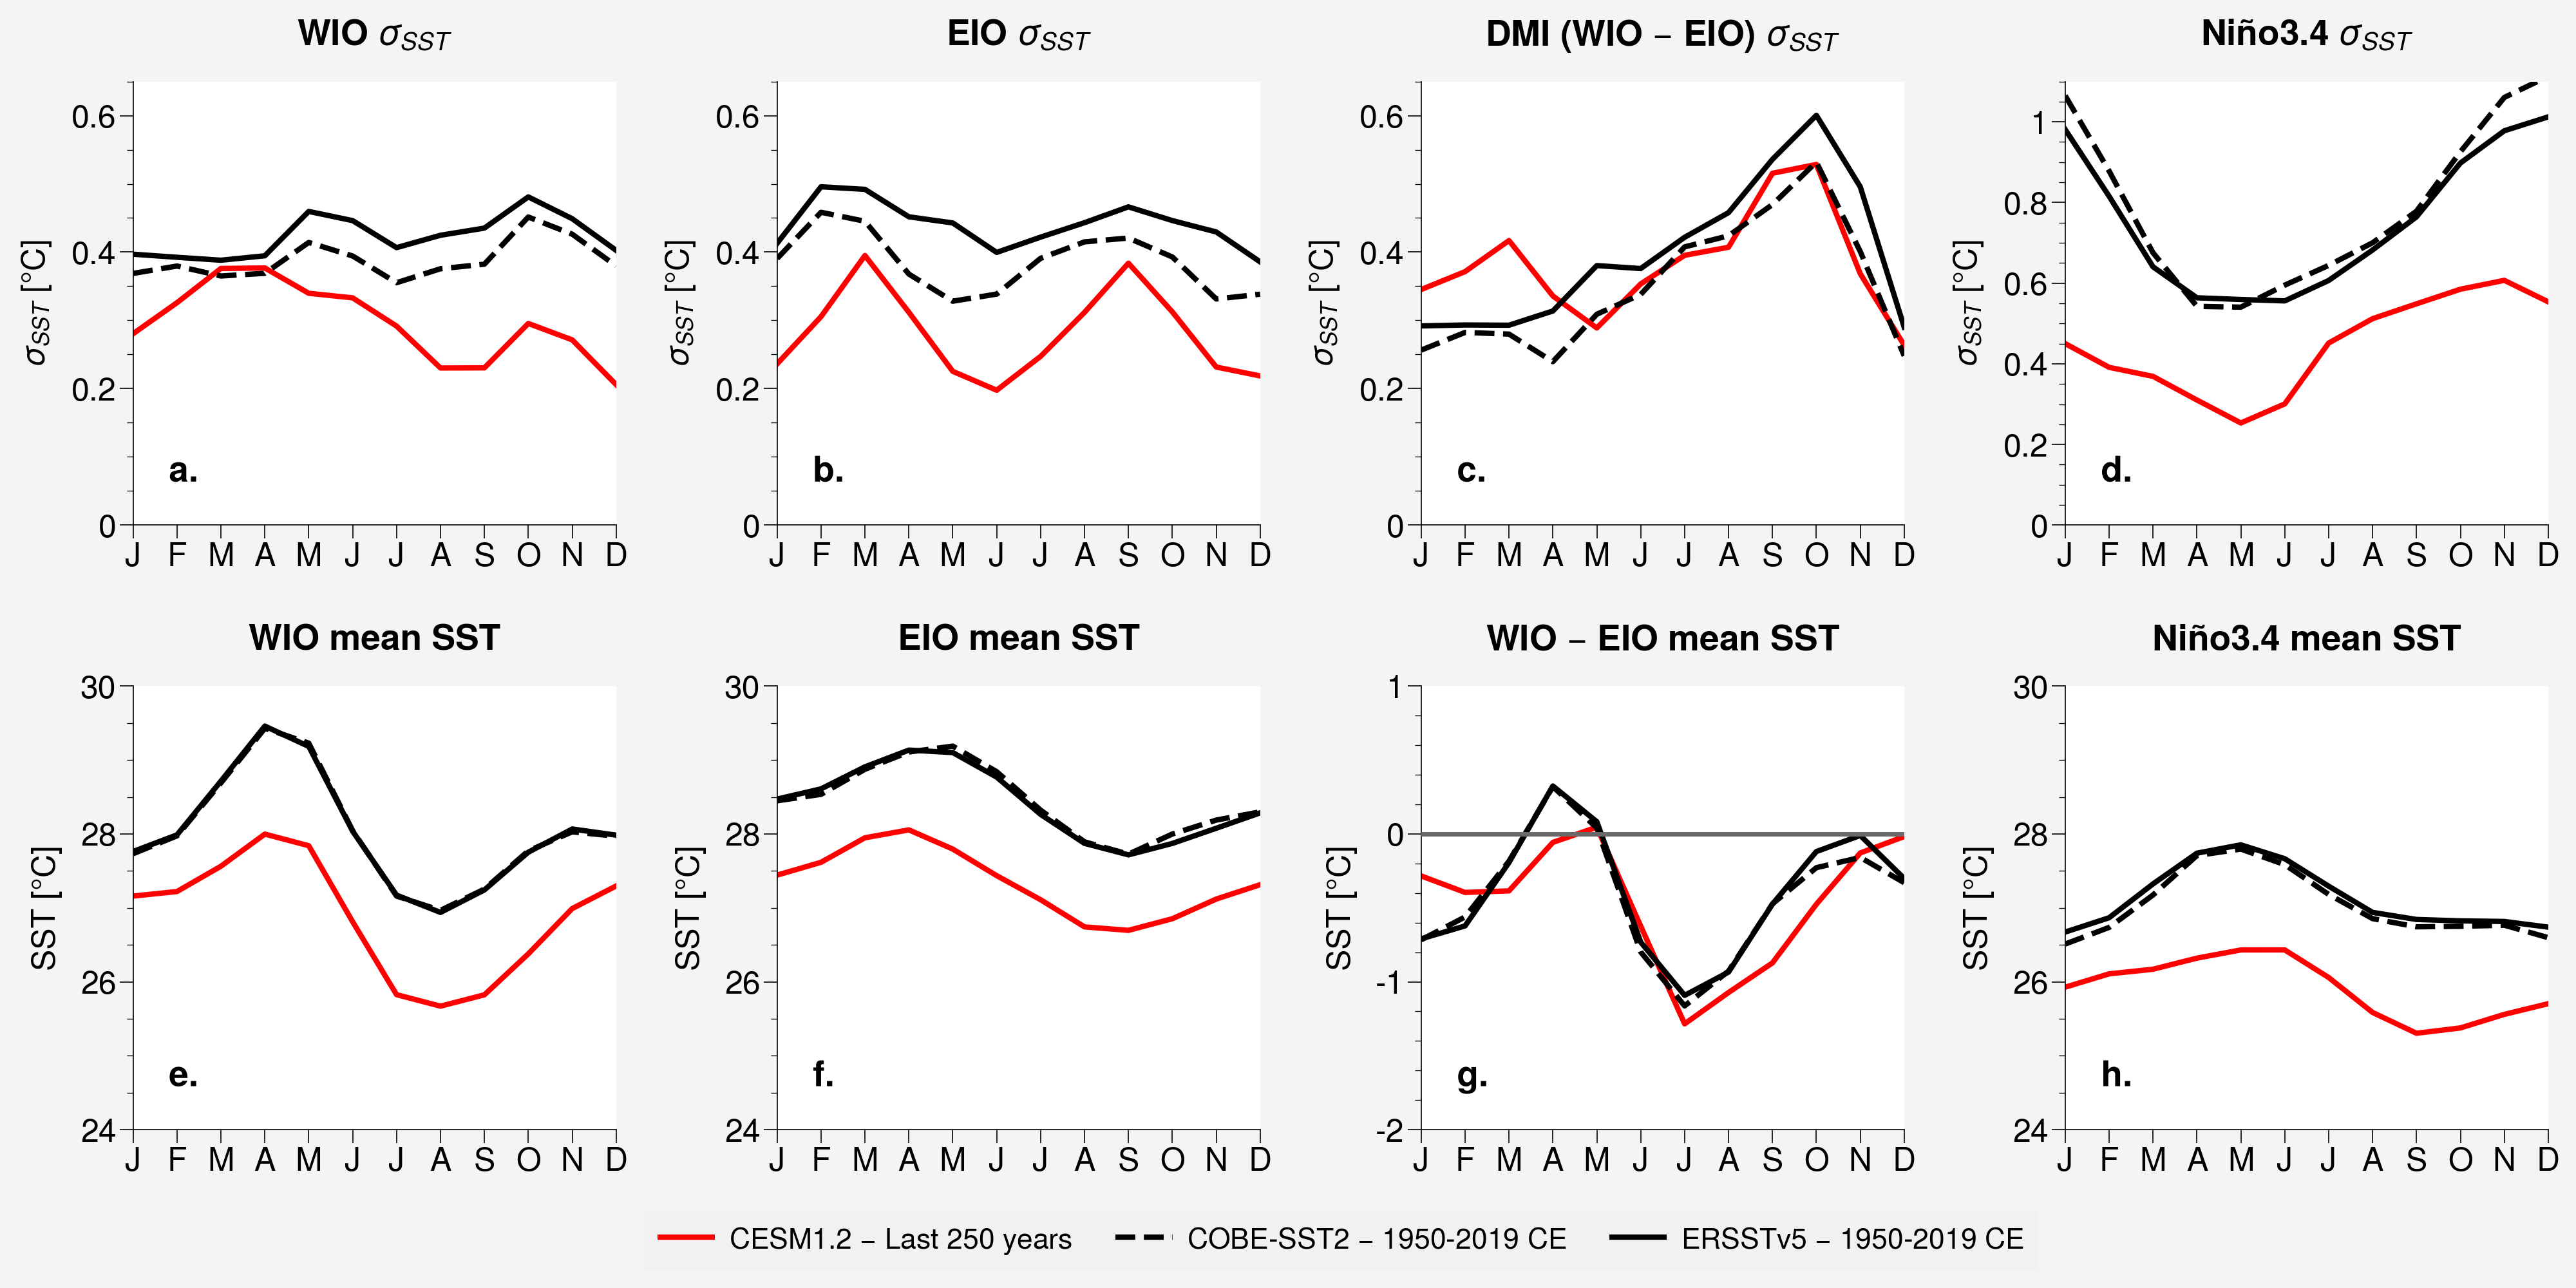

In [45]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

pplt.rc.update(grid=False, titleweight='bold', fontsize=18)

# Define the layout array
array = [
    [1, 2, 3, 4],
    [5, 6, 7, 8]
]

fig, axs = pplt.subplots(array,
                        figsize=(20,10), 
                         #refwidth=13.5, 
                         share=False,
                         hspace=5,wspace=5
                         )

for wio,eio,iod,nino34,c in zip([wio_cesm,wio_cobe,wio_ersstv5],
                                  [eio_cesm,eio_cobe, eio_ersstv5],
                                  [dmi_cesm,dmi_cobe, dmi_ersstv5],
                                  [nino34_cesm,nino34_cobe,nino34_ersstv5],
                                  ['r','k','k']):
    
    if nino34[0] == nino34_cobe[0]:
        linestyle = '--'
    else:
        linestyle = '-'

    # Plot standard deviation
    (wio.groupby('time.month').std()).plot(ax=axs[0],c=c,linestyle=linestyle,linewidth=3)
    (eio.groupby('time.month').std()).plot(ax=axs[1],c=c,linestyle=linestyle,linewidth=3)
    (iod.groupby('time.month').std()).plot(ax=axs[2],c=c,linestyle=linestyle,linewidth=3)
    (nino34.groupby('time.month').std()).plot(ax=axs[3],c=c,linestyle=linestyle,linewidth=3)

    # Plot mean
    (wio.groupby('time.month').mean()).plot(ax=axs[4],c=c,linestyle=linestyle,linewidth=3)
    (eio.groupby('time.month').mean()).plot(ax=axs[5],c=c,linestyle=linestyle,linewidth=3)
    (iod.groupby('time.month').mean()).plot(ax=axs[6],c=c,linestyle=linestyle,linewidth=3)
    (nino34.groupby('time.month').mean()).plot(ax=axs[7],c=c,linestyle=linestyle,linewidth=3)

# Set titles for standard deviation plots
axs[0].set_title(r'WIO $\sigma_{SST}$',pad=15)
axs[1].set_title(r'EIO $\sigma_{SST}$',pad=15)
axs[2].set_title(r'DMI (WIO $-$ EIO) $\sigma_{SST}$',pad=15)
axs[3].set_title(r'Niño3.4 $\sigma_{SST}$',pad=15)

# Set titles for mean plots
axs[4].set_title(r'WIO mean SST',pad=15)
axs[5].set_title(r'EIO mean SST',pad=15)
axs[6].set_title(r'WIO $-$ EIO mean SST',pad=15)
axs[7].set_title(r'Niño3.4 mean SST',pad=15)

for i, ax in enumerate(axs):
    ax.set_xlim(1,12)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.grid(False)
    ax.spines[['top','right']].set_visible(False)

    if i < 4:  # Standard deviation plots
        if (ax == axs[0]) or (ax == axs[1]) or (ax == axs[2]) or (ax == axs[3]):
            ax.set_ylabel(r'$\sigma_{SST}$ [°C]',labelpad=10)
        else:
            ax.set_ylabel('')
        # if (ax == axs[2]) or (ax == axs[3]):
        #     #ax.set_xlabel('Months',labelpad=10)
        #     pass
        # else:
        #     ax.set_xlabel('')
        if i == 3:
            ax.set_ylim(0,1.1)
            ax.set_yticks([0,.2,.4,.6,0.8, 1])    
        else:
            ax.set_ylim(0,0.65)
            ax.set_yticks([0,.2,.4,.6])
    else:  # Mean plots
        if (ax == axs[4]) or (ax == axs[5]) or (ax == axs[6]) or (ax == axs[7]) or (ax == axs[8]):
            ax.set_ylabel('SST [°C]',labelpad=10)
        else:
            ax.set_ylabel('')
        # if (ax == axs[6]) or (ax == axs[7]):
        #     #ax.set_xlabel('Months',labelpad=10)
        #     pass
        # else:
        #     ax.set_xlabel('')
        if ax == axs[6]:
            ax.set_ylim(-2,1)
            ax.set_yticks([-2,-1,0,1])
            ax.set_yticklabels([-2,-1,0,1])
            ax.axhline(0, linestyle='-', color='dimgrey', alpha=1, zorder=10, linewidth=2.5)
        else:
            ax.set_ylim(24,30)
            ax.set_yticks([24,26,28,30])
            ax.set_yticklabels([24,26,28,30])

legend_elements = [Line2D([0], [0], linewidth=3, color='r',label='CESM1.2 $-$ Last 250 years'),
                  Line2D([0], [0], linewidth=3, color='k',linestyle='--',label='COBE-SST2 $-$ 1950-2019 CE'),
                  Line2D([0], [0], linewidth=3, color='k',label='ERSSTv5 $-$ 1950-2019 CE')]

legend = fig.legend(handles=legend_elements, ncol=3, labelspacing=.45, fontsize=16, loc='bottom')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0.01))
legend.get_frame().set_linewidth(0.0)

axs.format(abc='a.',abcloc='ll', titleloc='c', titlepad=20,abctitlepad=10, 
xtickdir='out', ytickdir='out', xtickminor=False, ygridminor=False, ticklen=7.5, xlabel='') 

plt.savefig(f"/Users/iabdel/Library/CloudStorage/OneDrive-UQAM/Desktop/energy/cesm12.szn_combined_last50.png", dpi=300, format='png',
    bbox_inches='tight', pad_inches=.3,
    transparent=True
   )

plt.show()